In [51]:
import numpy as np
import pandas as pd
import re
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import ast
from sklearn.ensemble import RandomForestClassifier

In [363]:
#This function removes the outliers.Instead of discarding outliers at every column of data,outliers 
#are thrown for the observations where there are more than 10 columns whose corresponding values are more
#than 2 standard deviations away from their mean.
def remove_Outliers(churn_dataset_filtered_train):
    nrows = churn_dataset_filtered_train.shape[0]
    indexes_to_be_dropped = []
    for i in range(0,nrows):
        count = 0
        for col in churn_dataset_filtered_train.columns:
            if churn_dataset_filtered_train[col].iloc[[i]].values[0] >np.mean(churn_dataset_filtered_train[col])+2*np.std(churn_dataset_filtered_train[col]):
                count = count+1
            if count >10:
                indexes_to_be_dropped.append(i)
                break
    return indexes_to_be_dropped

In [365]:
#This function checks the validity of float,it is specifically used for the various float columns to check if the strings are
#valid floating point strings
def isFloat(s):
    if re.match("^\d+\.\d+$", s) is None:
        if re.match("^\d+",s) is None:
            return False
        else:
            return True
    return True

In [366]:
def isStrictlyFloat(s):
    if re.match("^\d+\.\d+$", s) is None:
        return False
    else:
        return True

In [367]:
#This function visualizes boxplots
def BoxPlot(churn_dataset_filtered_train,attributes):
    for attribute in attributes:
        cf = churn_dataset_filtered_train[~churn_dataset_filtered_train[attribute].isna()]
        churned_std_og_t2t = cf[cf['churn'] ==1]
        nonchurned_std_og_t2t = cf[cf['churn'] ==0]
        plt.boxplot(churned_std_og_t2t[attribute])
        plt.show()
        print(np.median(churned_std_og_t2t[attribute]))
        print(np.mean(churned_std_og_t2t[attribute]))
        plt.boxplot(nonchurned_std_og_t2t[attribute])
        plt.show()
        print(np.median(nonchurned_std_og_t2t[attribute]))
        print(np.mean(nonchurned_std_og_t2t[attribute]))

In [368]:
#This function imputes with the median
def ImputeMedian(churn_dataset_filtered_train,attributes):
    for attribute in attributes:
        cf = churn_dataset_filtered_train[~churn_dataset_filtered_train[attribute].isna()]
        notna_notchurn_loc_og_t2m_mou = cf[(cf['churn']==0)]
        notna_churn_loc_og_t2m_mou = cf[(cf['churn']==1)]
        churn_dataset_filtered_train.loc[((churn_dataset_filtered_train['churn'] ==1) &(churn_dataset_filtered_train[attribute].isna())),[attribute]]=np.median(notna_churn_loc_og_t2m_mou[attribute])
        churn_dataset_filtered_train.loc[((churn_dataset_filtered_train['churn'] ==0 )&(churn_dataset_filtered_train[attribute].isna())),[attribute]]=np.median(notna_notchurn_loc_og_t2m_mou[attribute])
        cf2 = churn_dataset_filtered_train[attribute]
        #churn_dataset_filtered_train = churn_dataset_filtered_train[churn_dataset_filtered_train[attribute]<np.percentile(list(cf2),98.5)]
    return churn_dataset_filtered_train

In [369]:
telecom_churn_data = pd.read_csv('telecom_churn_data.csv')

In [370]:
telecom_churn_data.shape

(99999, 226)

In [371]:
len(telecom_churn_data['mobile_number'].unique())

99999

The data set has 99999 rows and the number of unique mobile number is too 99999 hence each row corresponds to a unique mobile number

The next step to do would be identify the data of interest,the high value customers ,so for that lets look at total_rech_amt_6 and total_rech_amt_7

In [372]:
print(sum(telecom_churn_data['total_rech_amt_6'].isna()))
print(sum(telecom_churn_data['total_rech_amt_7'].isna()))
print(sum(telecom_churn_data['total_rech_num_7'].isna()))
print(sum(telecom_churn_data['total_rech_num_6'].isna()))

0
0
0
0


In [373]:
filter_amt_6 = list(filter(lambda x:isFloat(str(x)),telecom_churn_data['total_rech_amt_6']))
filter_amt_7 = list(filter(lambda x:isFloat(str(x)),telecom_churn_data['total_rech_amt_7']))
filter_rech_6 = list(filter(lambda x:isFloat(str(x)),telecom_churn_data['total_rech_num_6']))
filter_rech_7 = list(filter(lambda x:isFloat(str(x)),telecom_churn_data['total_rech_num_7']))

In [374]:
#len(filter_amt_6.to_list())
print(len(filter_amt_6))
print(len(filter_amt_7))
print(len(filter_rech_6))
print(len(filter_rech_7))

99999
99999
99999
99999


None of the columns pertaining to recharge amounts of first 2 months and none of the columns pertaining to number of times recharged have values other than floating point and all of them have 99999 values in total with no nan values.Hence data quality is verified 

In [375]:
#telecom_churn_data['avg_recharge_amt'] = telecom_churn_data.apply(lambda row:((telecom_churn_data['total_rech_amt_6']+telecom_churn_data['total_rech_amt_7'])/(telecom_churn_data['total_rech_num_6']+telecom_churn_data['total_rech_num_7'])),axis =1)
telecom_churn_data['avg_recharge_amt'] = 0

In [376]:
zeros_data = telecom_churn_data[(telecom_churn_data['total_rech_num_6'] ==0)]
zeros_data.shape

(1607, 227)

In [377]:
print(sum(zeros_data['total_rech_amt_6']>0))


0


In [378]:
zeros_data = telecom_churn_data[(telecom_churn_data['total_rech_num_7'] ==0)]
print(sum(zeros_data['total_rech_amt_7']>0))

0


The above code was to check that if the total recharge done is zero for months 6 and 7 then
the number of times  recharge done should too be zero.Its perfect that way

In [379]:
telecom_churn_data.loc[(((telecom_churn_data['count_rech_2g_6']==0)|(telecom_churn_data['count_rech_2g_6'].isna()))&(telecom_churn_data['date_of_last_rech_data_6'].isna())&((telecom_churn_data['count_rech_3g_6']==0)|(telecom_churn_data['count_rech_3g_6'].isna()))&((telecom_churn_data['av_rech_amt_data_6']==0)|(telecom_churn_data['av_rech_amt_data_6'].isna()))),['av_rech_amt_data_6','count_rech_3g_6','count_rech_2g_6']] = 0

In [380]:
print(sum(telecom_churn_data['av_rech_amt_data_6'].isna()))
print(sum(telecom_churn_data['count_rech_2g_6'].isna()))
print(sum(telecom_churn_data['count_rech_3g_6'].isna()))

0
0
0


Here we see that missing is consistent across count_rech_3g ,count_rech_2g,av_rech_2g and date of last rech data.If data is
not present for one its not present for anyone

In [381]:
#Assign the missing count and average with 0s
telecom_churn_data.loc[(((telecom_churn_data['count_rech_2g_7']==0)|(telecom_churn_data['count_rech_2g_7'].isna()))&(telecom_churn_data['date_of_last_rech_data_7'].isna())&((telecom_churn_data['count_rech_3g_7']==0)|(telecom_churn_data['count_rech_3g_7'].isna()))&((telecom_churn_data['av_rech_amt_data_7']==0)|(telecom_churn_data['av_rech_amt_data_7'].isna()))),['av_rech_amt_data_7','count_rech_3g_7','count_rech_2g_7']] = 0

In [382]:
print(sum(telecom_churn_data['av_rech_amt_data_7'].isna()))
print(sum(telecom_churn_data['count_rech_2g_7'].isna()))
print(sum(telecom_churn_data['count_rech_3g_7'].isna()))

0
0
0


In [383]:
telecom_churn_data.loc[(((telecom_churn_data['count_rech_2g_8']==0)|(telecom_churn_data['count_rech_2g_8'].isna()))&(telecom_churn_data['date_of_last_rech_data_8'].isna())&((telecom_churn_data['count_rech_3g_8']==0)|(telecom_churn_data['count_rech_3g_8'].isna()))&((telecom_churn_data['av_rech_amt_data_8']==0)|(telecom_churn_data['av_rech_amt_data_8'].isna()))),['av_rech_amt_data_8','count_rech_3g_8','count_rech_2g_8']] = 0

In [384]:
print(sum(telecom_churn_data['av_rech_amt_data_8'].isna()))
print(sum(telecom_churn_data['count_rech_2g_8'].isna()))
print(sum(telecom_churn_data['count_rech_3g_8'].isna()))

0
0
0


In [385]:
#get the total recharge by adding up the total recharges of talktime and data for months 6 and 7.
telecom_churn_data['total_data_rech_month_6'] = (telecom_churn_data['count_rech_2g_6']+telecom_churn_data['count_rech_3g_6'])*telecom_churn_data['av_rech_amt_data_6']
telecom_churn_data['total_data_rech_month_7'] = (telecom_churn_data['count_rech_2g_7']+telecom_churn_data['count_rech_3g_7'])*telecom_churn_data['av_rech_amt_data_7']

In [547]:
telecom_churn_data['total_data_rech_month_8'] = (telecom_churn_data['count_rech_2g_8']+telecom_churn_data['count_rech_3g_8'])*telecom_churn_data['av_rech_amt_data_8']

In [386]:
print(sum(telecom_churn_data['total_data_rech_month_6'].isna()))
print(sum(telecom_churn_data['total_data_rech_month_7'].isna()))

0
0


In [387]:
#Take the average recharges for months 6 and 7.
#telecom_churn_data['avg_recharge_amt'] = telecom_churn_data.apply(lambda row:((telecom_churn_data['total_rech_amt_6']+telecom_churn_data['total_rech_amt_7'])/(telecom_churn_data['total_rech_num_6']+telecom_churn_data['total_rech_num_7'])),axis =1)
telecom_churn_data['avg_recharge_amt'] = (telecom_churn_data['total_rech_amt_6']+telecom_churn_data['total_rech_amt_7']+telecom_churn_data['total_data_rech_month_6']+telecom_churn_data['total_data_rech_month_7'])/(2)
#telecom_churn_data.loc[telecom_churn_data['avg_recharge_amt'].isna(),['avg_recharge_amt'] ] =0

In [388]:
sum(telecom_churn_data['avg_recharge_amt'].isna())

0

In [389]:
telecom_churn_data['avg_recharge_amt'].head()
telecom_churn_data['avg_recharge_amt'].shape

(99999,)

In [390]:
np.percentile(list(telecom_churn_data['avg_recharge_amt']),70)

478.0

In [391]:
high_value_customers = telecom_churn_data[telecom_churn_data['avg_recharge_amt']>np.percentile(list(telecom_churn_data['avg_recharge_amt']),70)]

In [392]:
high_value_customers.shape

(29953, 229)

In [393]:
high_value_customers['churn'] = 0

C:\Users\Jabir_shabbir\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [394]:
high_value_customers.loc[((high_value_customers['total_ic_mou_9']==0)&(high_value_customers['total_og_mou_9']==0)&(high_value_customers['vol_2g_mb_9']==0)&(high_value_customers['vol_3g_mb_9']==0)),['churn']] = 1

C:\Users\Jabir_shabbir\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [395]:
sum(high_value_customers['churn'])

2433

In [396]:
high_value_customers.columns

Index(['mobile_number', 'circle_id', 'loc_og_t2o_mou', 'std_og_t2o_mou',
       'loc_ic_t2o_mou', 'last_date_of_month_6', 'last_date_of_month_7',
       'last_date_of_month_8', 'last_date_of_month_9', 'arpu_6',
       ...
       'fb_user_9', 'aon', 'aug_vbc_3g', 'jul_vbc_3g', 'jun_vbc_3g',
       'sep_vbc_3g', 'avg_recharge_amt', 'total_data_rech_month_6',
       'total_data_rech_month_7', 'churn'],
      dtype='object', length=230)

Drop off all the columns ending with _9 after identifying churners.

In [397]:
cols = list(filter( lambda x: ("_9" not in x) ,high_value_customers.columns))

In [398]:
churn_dataset = high_value_customers[cols]

In [399]:
churn_dataset.head()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,...,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g,avg_recharge_amt,total_data_rech_month_6,total_data_rech_month_7,churn
0,7000842753,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,197.385,214.816,...,1.0,968,30.40,0.00,101.20,3.58,559.0,252.0,252.0,1
7,7000701601,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,1069.180,1349.850,...,NaN,802,57.74,19.38,18.74,0.00,1185.0,0.0,0.0,1
8,7001524846,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,378.721,492.223,...,1.0,315,21.03,910.65,122.16,0.00,696.0,0.0,354.0,0
21,7002124215,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,514.453,597.753,...,NaN,720,0.00,0.00,0.00,0.00,640.0,0.0,0.0,0
23,7000887461,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,74.350,193.897,...,1.0,604,40.45,51.86,0.00,0.00,583.0,0.0,712.0,0


In [400]:
#Saving the churn data to csv file
churn_dataset.to_csv('churndataset.csv')

PermissionError: [Errno 13] Permission denied: 'churndataset.csv'

We can drop circle id as it is not significant since it is a categorical variable with just one value.

In [401]:
print(churn_dataset['circle_id'].unique())
print(sum(churn_dataset['circle_id'].isna()))

[109]
0


We can eliminate certain columns like date of last recharge,last recharge of data ,last date ,mobile number.As seve on use on business value,afterall the amount of recharge matters.

In [402]:
churn_dataset = churn_dataset.drop(['last_date_of_month_6','last_date_of_month_7','last_date_of_month_8','date_of_last_rech_6','date_of_last_rech_7','date_of_last_rech_6'],axis = 1)

Also drop another column called mobile number which server no purpose in business problem

In [403]:
churn_dataset = churn_dataset.drop(['mobile_number'],axis = 1)

In [404]:
len(churn_dataset.columns)

170

In [405]:
backup_data_frame = churn_dataset

In [406]:
churn_dataset = backup_data_frame

First lets consider attributes which could possibly be useful in determining churn.


Arpu is not useful attribute as the the tax of paid by the mobile operators

In [407]:
#The columns with arpu can be dropped as the revenue could be in way determined by recharge amount,so lets drop the columns with arpu
newcols = list(filter(lambda x:('arpu' not in x), list(churn_dataset.columns)))
churn_dataset_filtered = churn_dataset[newcols]

In [408]:
churn_dataset_filtered = churn_dataset[newcols]

In [409]:
#print(newcols)
len(churn_dataset_filtered.columns)

161

In [410]:
#Lets consider the categories of attributes one by one.
#Firstly lets consider local calls
#1.local calls outgoing to other operator fixed line
sum(churn_dataset_filtered['loc_og_t2o_mou'].isna())

223

In [411]:
cf = churn_dataset_filtered[~churn_dataset_filtered['loc_og_t2o_mou'].isna()]
cf['loc_og_t2o_mou'].mean()

0.0

In [412]:
#Since all the values are zero in it,it does not serve any meaningful info for regression,so drop it.Since the number of 
#minutes cannot be negative,hence all non null values are zero
churn_dataset_filtered_1 = churn_dataset_filtered.drop(['loc_og_t2o_mou'],axis = 1)

In [413]:
cf = churn_dataset_filtered_1[~churn_dataset_filtered_1['std_og_t2o_mou'].isna()]
cf['std_og_t2o_mou'].mean()

0.0

In [414]:
#Since all the non null values are zero again it does not serve any meaningful infromation for regression.It can be dropped.Since the number of 
#minutes cannot be negative,hence all non null values are zero
churn_dataset_filtered_2 = churn_dataset_filtered_1.drop(['std_og_t2o_mou'],axis = 1)

In [415]:
#The same goes with loc_ic_t2o_mou as well
cf = churn_dataset_filtered_2[~churn_dataset_filtered_2['loc_ic_t2o_mou'].isna()]
cf['loc_ic_t2o_mou'].mean()

0.0

In [416]:
churn_dataset_filtered_3 = churn_dataset_filtered_2.drop(['loc_ic_t2o_mou'],axis = 1)

In [417]:
churn_dataset_filtered_train = churn_dataset_filtered_3

In [418]:
print(churn_dataset_filtered_train.shape)
#print(churn_dataset_filtered_test.shape)

(29953, 158)


In [419]:
#The same goes with loc_ic_t2o_mou as well
cf = churn_dataset_filtered_train[churn_dataset_filtered_train['loc_og_t2t_mou_6'].isna()]
print(cf.shape)
#cf['loc_ic_t2o_mou'].mean()

(542, 158)


In [420]:
cf = churn_dataset_filtered_train[~churn_dataset_filtered_train['loc_og_t2t_mou_6'].isna()]
cf['loc_og_t2t_mou_6'].mean()

86.13269423004658

{'whiskers': [<matplotlib.lines.Line2D at 0x6702600208>,
 'caps': [<matplotlib.lines.Line2D at 0x670394d948>,
 'boxes': [<matplotlib.lines.Line2D at 0x670393cfc8>],
 'medians': [<matplotlib.lines.Line2D at 0x6700ef6e08>],
 'fliers': [<matplotlib.lines.Line2D at 0x6700ef6108>],
 'means': []}

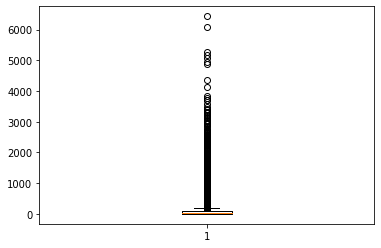

In [421]:
plt.boxplot(cf['loc_og_t2t_mou_6'])

In [422]:
#There is of course skewness in the data.However lets check the distribution of churn and not churn in this dataset.
#cf.groupby('churn')['onnet_mou_6'].count()
print(cf.shape)
sum(cf['churn'])
#1523 have churned

(29411, 158)


2281

15.09

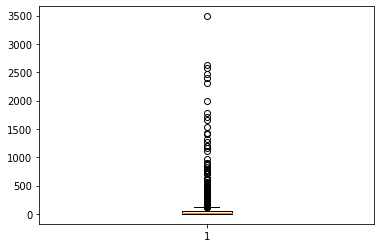

In [423]:
churned_nonna_loc_og_t2t_mou_6 = cf[cf['churn'] ==1]
plt.boxplot(churned_nonna_loc_og_t2t_mou_6['loc_og_t2t_mou_6'])
np.median(churned_nonna_loc_og_t2t_mou_6['loc_og_t2t_mou_6'])

26.619999999999997

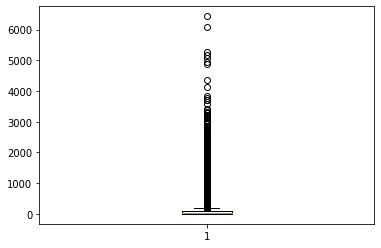

In [424]:
churned_nonna_loc_og_t2t_mou_6 = cf[cf['churn'] ==0]
plt.boxplot(churned_nonna_loc_og_t2t_mou_6['loc_og_t2t_mou_6'])
np.median(churned_nonna_loc_og_t2t_mou_6['loc_og_t2t_mou_6'])

In [425]:
cf2 = churn_dataset_filtered_train[churn_dataset_filtered_train['loc_og_t2t_mou_6'].isna()]
#print(cf2.groupby('churn')['onnet_mou_6'].count())
print(cf2.shape)
sum(cf2['churn'])
#Here 320 have churned which is considerable quite large when the dataset is imbalanced ,we must consider
#imputing these values.

(542, 158)


152

In [426]:
#impute the values of na's with their respective medians of groups of churned and unchurned
#churn_dataset_filtered_train
churn_dataset_filtered_train = ImputeMedian(churn_dataset_filtered_train,['loc_og_t2t_mou_6'])

In [427]:
cf = churn_dataset_filtered_train[~churn_dataset_filtered_train['loc_og_t2t_mou_7'].isna()]
cf['loc_og_t2t_mou_7'].mean()

87.32549920113934

10.96

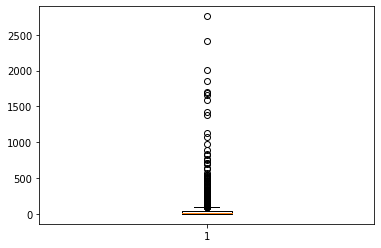

In [428]:
notna_churn_loc_og_t2t_mou_7 = cf[(cf['churn']==1)]

plt.boxplot(notna_churn_loc_og_t2t_mou_7['loc_og_t2t_mou_7'])
np.median(notna_churn_loc_og_t2t_mou_7['loc_og_t2t_mou_7'])

27.415

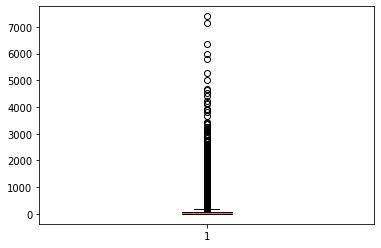

In [429]:
notna_churn_loc_og_t2t_mou_7 = cf[(cf['churn']==0)]

plt.boxplot(notna_churn_loc_og_t2t_mou_7['loc_og_t2t_mou_7'])
np.median(notna_churn_loc_og_t2t_mou_7['loc_og_t2t_mou_7'])

In [430]:
#Print the count churns and non churns when there are nas
cf2 = churn_dataset_filtered_train[churn_dataset_filtered_train['loc_og_t2t_mou_7'].isna()]
print(cf2.shape)
print(cf2[cf2['churn']==1].shape)
print(cf2[cf2['churn']==0].shape)

(536, 158)
(214, 158)
(322, 158)


In [431]:
#churn_dataset_filtered_train.loc[((churn_dataset_filtered_train['churn'] ==1) &(churn_dataset_filtered_train['loc_og_t2t_mou_7'].isna())),['loc_og_t2t_mou_7']] =8.23
#churn_dataset_filtered_train.loc[((churn_dataset_filtered_train['churn'] ==0 )&(churn_dataset_filtered_train['loc_og_t2t_mou_7'].isna())),['loc_og_t2t_mou_7']] =29.96
churn_dataset_filtered_train = ImputeMedian(churn_dataset_filtered_train,['loc_og_t2t_mou_7'])


In [432]:
cf = churn_dataset_filtered_train[~churn_dataset_filtered_train['loc_og_t2t_mou_8'].isna()]
cf['loc_og_t2t_mou_8'].mean()

81.33583961641112

1.02

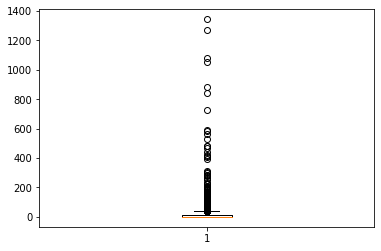

In [433]:
notna_churn_loc_og_t2t_mou_8 = cf[(cf['churn']==1)]

plt.boxplot(notna_churn_loc_og_t2t_mou_8['loc_og_t2t_mou_8'])
np.median(notna_churn_loc_og_t2t_mou_8['loc_og_t2t_mou_8'])

25.48

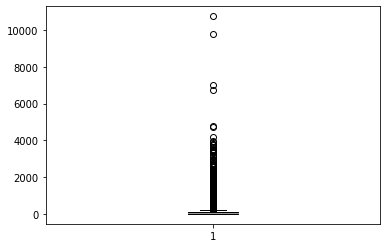

In [434]:
notna_churn_loc_og_t2t_mou_8 = cf[(cf['churn']==0)]

plt.boxplot(notna_churn_loc_og_t2t_mou_8['loc_og_t2t_mou_8'])
np.median(notna_churn_loc_og_t2t_mou_8['loc_og_t2t_mou_8'])

In [435]:
#Print the count churns and non churns when there are nas
cf2 = churn_dataset_filtered_train[churn_dataset_filtered_train['loc_og_t2t_mou_8'].isna()]
print(cf2.shape)
print(cf2[cf2['churn']==1].shape)
print(cf2[cf2['churn']==0].shape)

(1172, 158)
(793, 158)
(379, 158)


In [436]:
#churn_dataset_filtered_train.loc[((churn_dataset_filtered_train['churn'] ==1) &(churn_dataset_filtered_train['loc_og_t2t_mou_8'].isna())),['loc_og_t2t_mou_8']] =0.02
#churn_dataset_filtered_train.loc[((churn_dataset_filtered_train['churn'] ==0 )&(churn_dataset_filtered_train['loc_og_t2t_mou_8'].isna())),['loc_og_t2t_mou_8']] =28.76
churn_dataset_filtered_train = ImputeMedian(churn_dataset_filtered_train,['loc_og_t2t_mou_8'])

In [437]:
#Now lets take the next attribute log_og_t2m_mou_6 and check non na values of it
cf = churn_dataset_filtered_train[~churn_dataset_filtered_train['loc_og_t2m_mou_6'].isna()]
cf['loc_og_t2m_mou_6'].mean()

166.31909251640516

45.34

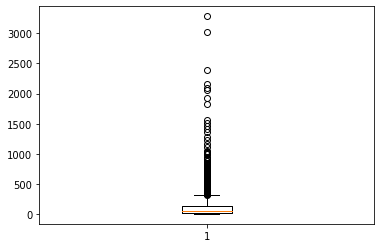

In [438]:
notna_churn_loc_og_t2m_mou_6 = cf[(cf['churn']==1)]

plt.boxplot(notna_churn_loc_og_t2m_mou_6['loc_og_t2m_mou_6'])
np.median(notna_churn_loc_og_t2m_mou_6['loc_og_t2m_mou_6'])

83.57

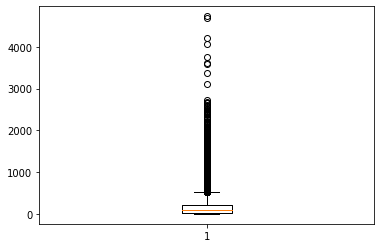

In [439]:
notna_churn_loc_og_t2m_mou_6 = cf[(cf['churn']==0)]

plt.boxplot(notna_churn_loc_og_t2m_mou_6['loc_og_t2m_mou_6'])
np.median(notna_churn_loc_og_t2m_mou_6['loc_og_t2m_mou_6'])

In [440]:
#Print the count churns and non churns when there are nas
cf2 = churn_dataset_filtered_train[churn_dataset_filtered_train['loc_og_t2m_mou_6'].isna()]
print(cf2.shape)
print(cf2[cf2['churn']==1].shape)
print(cf2[cf2['churn']==0].shape)

(542, 158)
(152, 158)
(390, 158)


We can impute them respectively with the median of their classes as the values for loc_og_t2m_mou_6 are highly skewed

In [441]:
#churn_dataset_filtered_train.loc[((churn_dataset_filtered_train['churn'] ==1) &(churn_dataset_filtered_train['loc_og_t2m_mou_6'].isna())),['loc_og_t2m_mou_6']] =44.98
#churn_dataset_filtered_train.loc[((churn_dataset_filtered_train['churn'] ==0 )&(churn_dataset_filtered_train['loc_og_t2m_mou_6'].isna())),['loc_og_t2m_mou_6']] =91.33
churn_dataset_filtered_train = ImputeMedian(churn_dataset_filtered_train,['loc_og_t2m_mou_6'])

In [442]:
#Since there are many attributes we can repeat the process iteratively for all of them in a loop
attributes = ['loc_og_t2m_mou_7','loc_og_t2m_mou_8','loc_og_t2f_mou_6','loc_og_t2f_mou_7','loc_og_t2f_mou_8']
for attribute in attributes:
    cf = churn_dataset_filtered_train[~churn_dataset_filtered_train[attribute].isna()]
    notna_notchurn_loc_og_t2m_mou = cf[(cf['churn']==0)]
    notna_churn_loc_og_t2m_mou = cf[(cf['churn']==1)]
    churn_dataset_filtered_train.loc[((churn_dataset_filtered_train['churn'] ==1) &(churn_dataset_filtered_train[attribute].isna())),[attribute]]=np.median(notna_churn_loc_og_t2m_mou[attribute])
    churn_dataset_filtered_train.loc[((churn_dataset_filtered_train['churn'] ==0 )&(churn_dataset_filtered_train[attribute].isna())),[attribute]]=np.median(notna_notchurn_loc_og_t2m_mou[attribute])
    cf2 = churn_dataset_filtered_train[attribute]
    #churn_dataset_filtered_train = churn_dataset_filtered_train[churn_dataset_filtered_train[attribute]<np.percentile(list(cf2),98.5)]

0.0
0.0


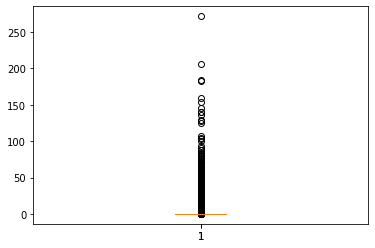

In [443]:
cf = churn_dataset_filtered_train[~churn_dataset_filtered_train['loc_og_t2c_mou_6'].isna()]
notna_notchurn_loc_og_t2c_mou = cf[(cf['churn']==0)]
notna_churn_loc_og_t2c_mou = cf[(cf['churn']==1)]
plt.boxplot(notna_notchurn_loc_og_t2c_mou['loc_og_t2c_mou_6'])
print(np.median(notna_notchurn_loc_og_t2c_mou['loc_og_t2c_mou_6']))
plt.boxplot(notna_churn_loc_og_t2c_mou['loc_og_t2c_mou_6'])
print(np.median(notna_churn_loc_og_t2c_mou['loc_og_t2c_mou_6']))

In [444]:
print(np.mean(notna_notchurn_loc_og_t2c_mou['loc_og_t2c_mou_6']))
print(np.mean(notna_churn_loc_og_t2c_mou['loc_og_t2c_mou_6']))

1.6001666052340802
1.6811617711530056


As we see both mean and median is more or less similar close to zero and 1 ,this column can be dropped off,however the number
of times the person makes calls to call center can be determining factor for churn as if the people are not happy with service
they frequently call the call center,we can let the model decide on this.


In [445]:
attributes = ['loc_og_t2c_mou_6','loc_og_t2c_mou_7','loc_og_t2c_mou_8']

In [446]:
#We observe that the distribution is more or less similar for other month calls 6 and 7 to call center,hence they can be imputed similarly
churn_dataset_filtered_train = ImputeMedian(churn_dataset_filtered_train,attributes)

In [447]:
#Further we can drop the attributes corresponding to total calls,as they are just the sum of columns corresponding to ouutgoing calls
churn_dataset_filtered_train = churn_dataset_filtered_train.drop(['loc_og_mou_6','loc_og_mou_7','loc_og_mou_8'],axis = 1)
#churn_dataset_filtered_train['log_og_mou_6'].head()
churn_dataset_filtered_train.shape

(29953, 155)

Now we can have a look at std outgoing calls

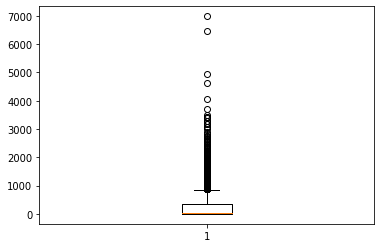

31.13


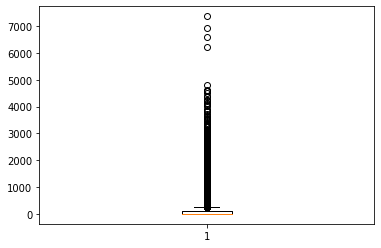

2.61


In [448]:
cf = churn_dataset_filtered_train[~churn_dataset_filtered_train['std_og_t2t_mou_6'].isna()]
churned_std_og_t2t = cf[cf['churn'] ==1]
nonchurned_std_og_t2t = cf[cf['churn'] ==0]
plt.boxplot(churned_std_og_t2t['std_og_t2t_mou_6'])
plt.show()
print(np.median(churned_std_og_t2t['std_og_t2t_mou_6']))
plt.boxplot(nonchurned_std_og_t2t['std_og_t2t_mou_6'])
plt.show()
print(np.median(nonchurned_std_og_t2t['std_og_t2t_mou_6']))

This is interesting contrary to local calls the churned users have higher std usage for outgoing calls of this category.
Lets check for std calls of other categories too

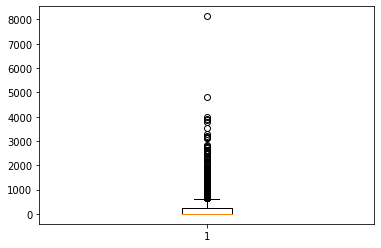

15.71


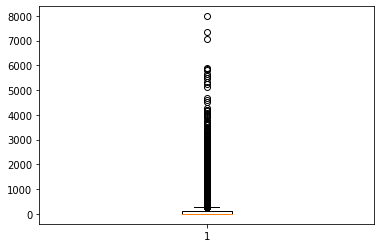

2.83


In [449]:
cf = churn_dataset_filtered_train[~churn_dataset_filtered_train['std_og_t2t_mou_7'].isna()]
churned_std_og_t2t = cf[cf['churn'] ==1]
nonchurned_std_og_t2t = cf[cf['churn'] ==0]
plt.boxplot(churned_std_og_t2t['std_og_t2t_mou_7'])
plt.show()
print(np.median(churned_std_og_t2t['std_og_t2t_mou_7']))
plt.boxplot(nonchurned_std_og_t2t['std_og_t2t_mou_7'])
plt.show()
print(np.median(nonchurned_std_og_t2t['std_og_t2t_mou_7']))

Again the same is true for month 7 too.We will now impute the missing the missing values with median for all 3 categories of months 6,7,8.

In [450]:
attributes = ['std_og_t2t_mou_6','std_og_t2t_mou_7','std_og_t2t_mou_8']
churn_dataset_filtered_train = ImputeMedian(churn_dataset_filtered_train,attributes)

We missed out the analysis of local mobile to fixed line.

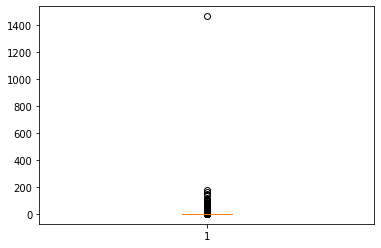

0.0


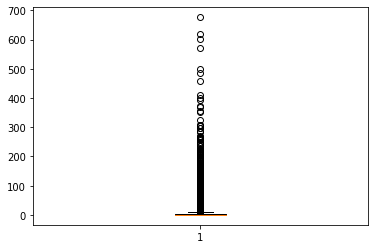

0.26


In [451]:
cf = churn_dataset_filtered_train[~churn_dataset_filtered_train['loc_og_t2f_mou_6'].isna()]
churned_std_og_t2t = cf[cf['churn'] ==1]
nonchurned_std_og_t2t = cf[cf['churn'] ==0]
plt.boxplot(churned_std_og_t2t['loc_og_t2f_mou_6'])
plt.show()
print(np.median(churned_std_og_t2t['loc_og_t2f_mou_6']))
plt.boxplot(nonchurned_std_og_t2t['loc_og_t2f_mou_6'])
plt.show()
print(np.median(nonchurned_std_og_t2t['loc_og_t2f_mou_6']))

In [452]:
print(np.mean(churned_std_og_t2t['loc_og_t2f_mou_6']))
print(np.mean(nonchurned_std_og_t2t['loc_og_t2f_mou_6']))

3.6239457459926014
6.5928913517440515


There does not seem to be much difference in the means and medians of churns and non churns in case of local outgoing calls to same operator fixed line

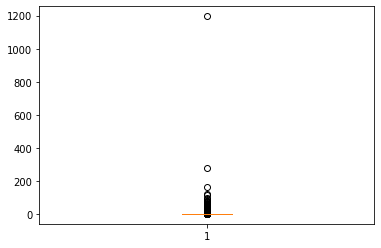

0.0


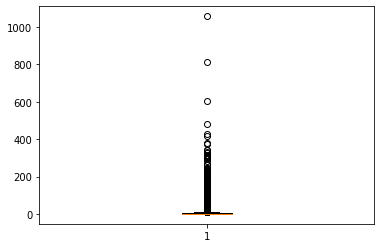

0.33


In [453]:
cf = churn_dataset_filtered_train[~churn_dataset_filtered_train['loc_og_t2f_mou_7'].isna()]
churned_std_og_t2t = cf[cf['churn'] ==1]
nonchurned_std_og_t2t = cf[cf['churn'] ==0]
plt.boxplot(churned_std_og_t2t['loc_og_t2f_mou_7'])
plt.show()
print(np.median(churned_std_og_t2t['loc_og_t2f_mou_7']))
plt.boxplot(nonchurned_std_og_t2t['loc_og_t2f_mou_7'])
plt.show()
print(np.median(nonchurned_std_og_t2t['loc_og_t2f_mou_7']))

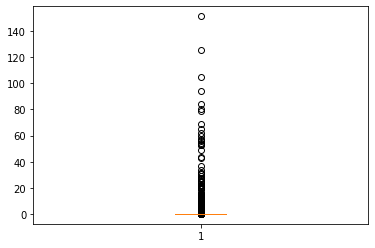

0.0


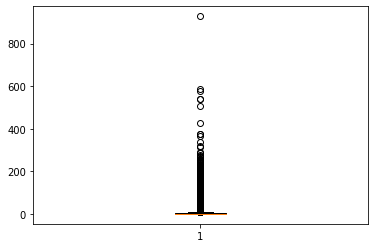

0.25


In [454]:
cf = churn_dataset_filtered_train[~churn_dataset_filtered_train['loc_og_t2f_mou_8'].isna()]
churned_std_og_t2t = cf[cf['churn'] ==1]
nonchurned_std_og_t2t = cf[cf['churn'] ==0]
plt.boxplot(churned_std_og_t2t['loc_og_t2f_mou_8'])
plt.show()
print(np.median(churned_std_og_t2t['loc_og_t2f_mou_8']))
plt.boxplot(nonchurned_std_og_t2t['loc_og_t2f_mou_8'])
plt.show()
print(np.median(nonchurned_std_og_t2t['loc_og_t2f_mou_8']))

In [455]:
attributes = ['loc_og_t2f_mou_6','loc_og_t2f_mou_7','loc_og_t2f_mou_8']
churn_dataset_filtered_train = ImputeMedian(churn_dataset_filtered_train,attributes)

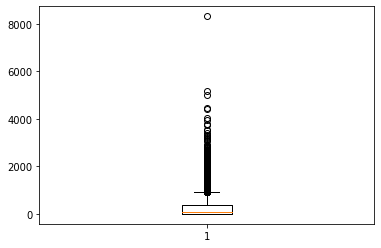

64.49


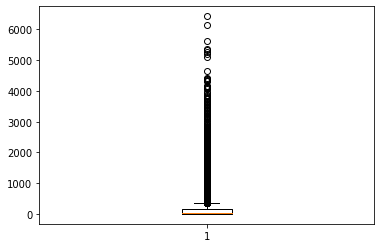

16.21


In [456]:
cf = churn_dataset_filtered_train[~churn_dataset_filtered_train['std_og_t2m_mou_6'].isna()]
churned_std_og_t2t = cf[cf['churn'] ==1]
nonchurned_std_og_t2t = cf[cf['churn'] ==0]
plt.boxplot(churned_std_og_t2t['std_og_t2m_mou_6'])
plt.show()
print(np.median(churned_std_og_t2t['std_og_t2m_mou_6']))
plt.boxplot(nonchurned_std_og_t2t['std_og_t2m_mou_6'])
plt.show()
print(np.median(nonchurned_std_og_t2t['std_og_t2m_mou_6']))

Here we see indeed there is difference in median values of outgoing std calls to other operators
between those who have churned and those not churned

In [457]:
#We can impute missing values with the median for all outgoing std to other lines
cf = churn_dataset_filtered_train[churn_dataset_filtered_train['std_og_t2m_mou_6'].isna()]
#cf.shape
attributes = ['std_og_t2m_mou_6','std_og_t2m_mou_7','std_og_t2m_mou_8']
churn_dataset_filtered_train = ImputeMedian(churn_dataset_filtered_train,attributes)

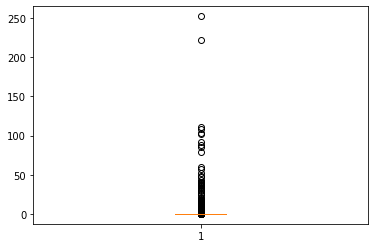

0.0


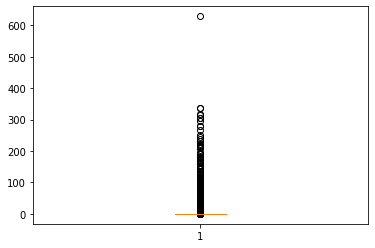

0.0


In [458]:
cf = churn_dataset_filtered_train[~churn_dataset_filtered_train['std_og_t2f_mou_6'].isna()]
churned_std_og_t2t = cf[cf['churn'] ==1]
nonchurned_std_og_t2t = cf[cf['churn'] ==0]
plt.boxplot(churned_std_og_t2t['std_og_t2f_mou_6'])
plt.show()
print(np.median(churned_std_og_t2t['std_og_t2f_mou_6']))
plt.boxplot(nonchurned_std_og_t2t['std_og_t2f_mou_6'])
plt.show()
print(np.median(nonchurned_std_og_t2t['std_og_t2f_mou_6']))

In [459]:
print(np.mean(nonchurned_std_og_t2t['std_og_t2f_mou_6']))
print(np.median(nonchurned_std_og_t2t['std_og_t2f_mou_6']))

1.884336527828988
0.0


Although the distribution of churn and not churn seems to be more or less similar there is slight difference in their mean.
We can consider this for our model and let model decide if the variable is significant

We can do this for all months of std_t2f 6,7,8

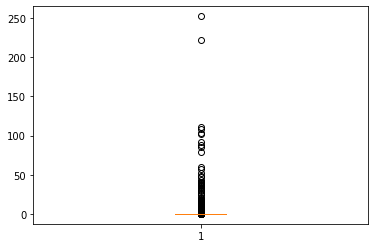

0.0
1.307233669443227


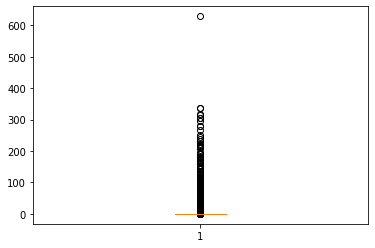

0.0
1.884336527828988


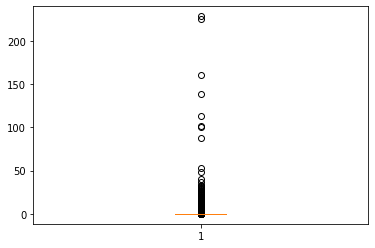

0.0
1.1919333032897723


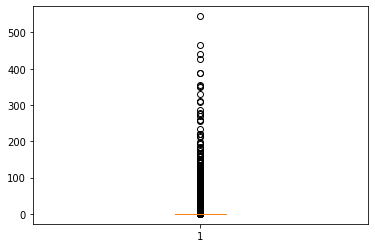

0.0
1.9163192146481518


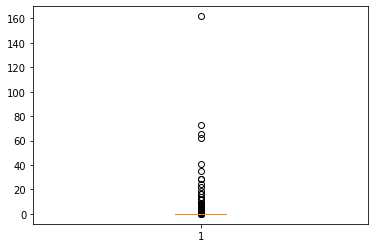

0.0
0.49137195121951227


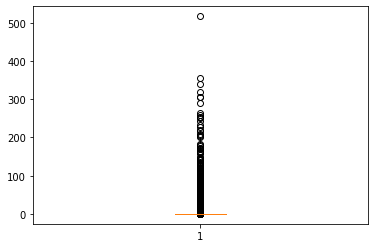

0.0
1.7214483622563759


In [460]:
attributes = ['std_og_t2f_mou_6','std_og_t2f_mou_7','std_og_t2f_mou_8']
BoxPlot(churn_dataset_filtered_train,attributes)
#churn_dataset_filtered_train.columns

In [461]:
attributes = ['std_og_t2f_mou_6','std_og_t2f_mou_7','std_og_t2f_mou_8']
churn_dataset_filtered_train = ImputeMedian(churn_dataset_filtered_train,attributes)

Now lets look at the calls of std to call centers

In [462]:
attributes = ['std_og_t2c_mou_6','std_og_t2c_mou_7','std_og_t2c_mou_8']
print(sum(churn_dataset_filtered_train['std_og_t2c_mou_6']>0))
print(sum(churn_dataset_filtered_train['std_og_t2c_mou_7']>0))
print(sum(churn_dataset_filtered_train['std_og_t2c_mou_8']>0))

0
0
0


In [463]:
churn_dataset_filtered_train = churn_dataset_filtered_train.drop(attributes,axis = 1)

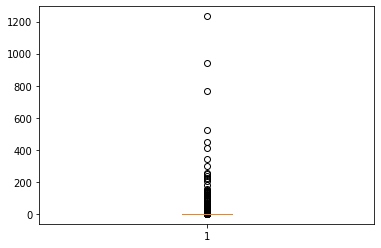

0.0
4.63994300745287


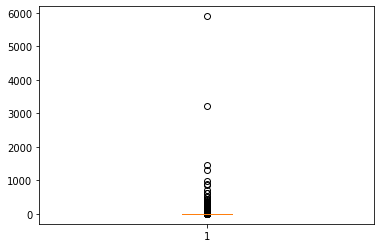

0.0
2.0112019904165233


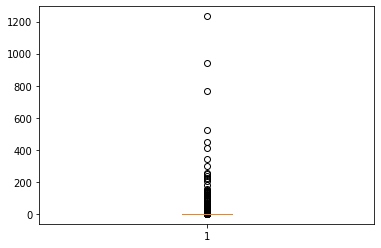

0.0
4.63994300745287


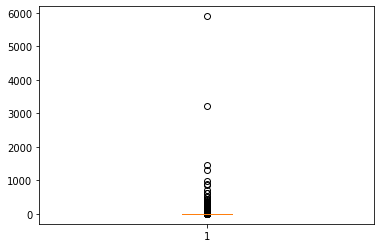

0.0
2.0112019904165233


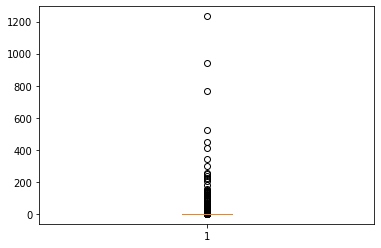

0.0
4.63994300745287


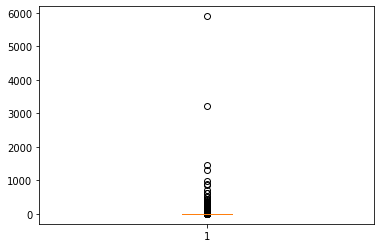

0.0
2.0112019904165233


In [464]:
attributes = ['isd_og_mou_6','isd_og_mou_6','isd_og_mou_6']
BoxPlot(churn_dataset_filtered_train,attributes)

Although the median is 0 for all 3 months in case isd outgoing calls,however is is some difference in the means.
We can impute the data with median as it is quite skewed,isd calls are slightly higher in duration in case of churn


In [465]:
attributes = ['isd_og_mou_6','isd_og_mou_7','isd_og_mou_8']
churn_dataset_filtered_train = ImputeMedian(churn_dataset_filtered_train,attributes)

In [466]:
churn_dataset_filtered_train.shape

(29953, 152)

Now lets check the special calls distributions

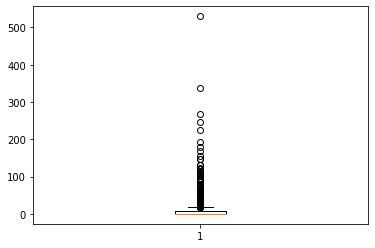

0.75
7.674300745287139


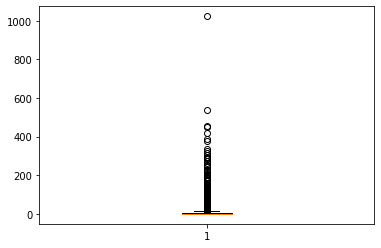

0.28
5.785973461113038


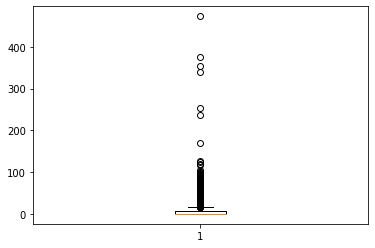

0.78
8.053433979269935


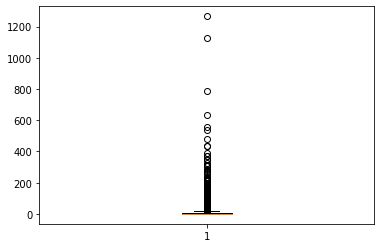

0.81
7.1695297448340325


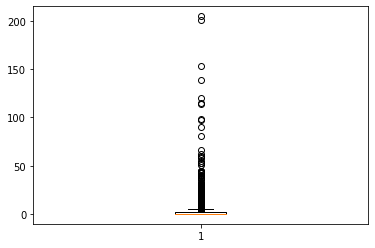

0.0
3.9994634146341457


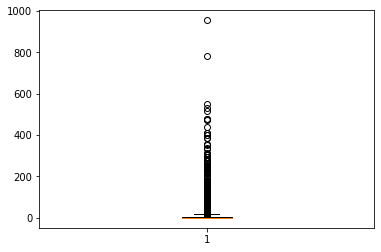

0.78
6.985881139235673


In [467]:
attributes = ['spl_og_mou_6','spl_og_mou_7','spl_og_mou_8']
BoxPlot(churn_dataset_filtered_train,attributes)

In [468]:
#We see that the median is close to zero but there are differences in mean,not sure if its statistically significant we cant
#let the model decide this.However lets impute the vallues with the median.
churn_dataset_filtered_train = ImputeMedian(churn_dataset_filtered_train,attributes)


We can drop the column og_others as it does not seem to add value in terms of business and it has most of the values as 0 upto 88 percentile

In [469]:
cf = churn_dataset_filtered_train[~churn_dataset_filtered_train['og_others_6'].isna()]
np.percentile(cf['og_others_6'],88)

1.6799999999999997

In [470]:
churn_dataset_filtered_train = churn_dataset_filtered_train.drop(['og_others_6','og_others_7','og_others_8'],axis = 1)

We can also get rid of the variables corressponding to total minutes of outgoing calls ,as they are already redundant since we have the minutes for individual months

In [471]:
churn_dataset_filtered_train = churn_dataset_filtered_train.drop(['total_og_mou_6','total_og_mou_7','total_og_mou_8'],axis = 1)

Now lets check the columns corressponding to incoming calls of various types.

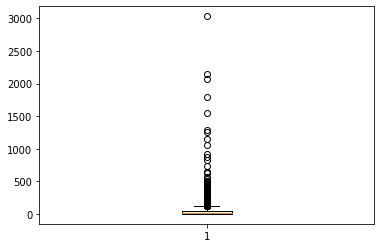

15.49
50.32517316966239


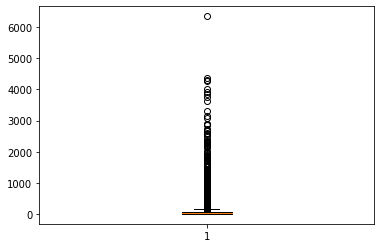

26.88
68.09424364172307


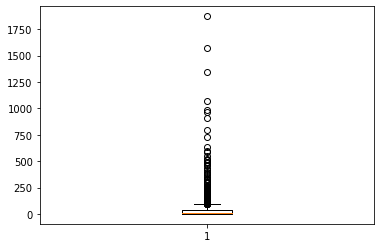

12.79
39.115804416403684


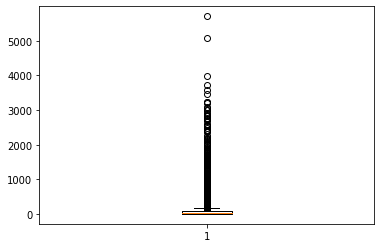

28.0
70.25058349878488


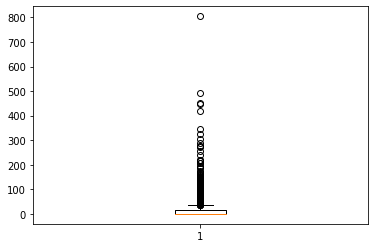

1.585
18.163658536585405


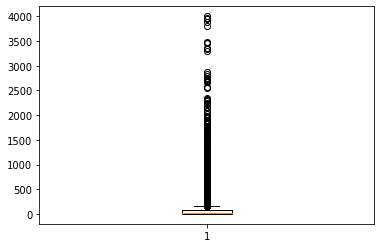

26.83
68.05712317158356


In [472]:
attributes = ['loc_ic_t2t_mou_6','loc_ic_t2t_mou_7','loc_ic_t2t_mou_8']
BoxPlot(churn_dataset_filtered_train,attributes)

In [473]:
# We see there is a significant difference in the distributions of incoming calls within same operators
#More ever the data is highly skewed,hence we can impute the missing values with medians.
churn_dataset_filtered_train = ImputeMedian(churn_dataset_filtered_train,attributes)

Now lets check the distribution of other incoming calls from operators

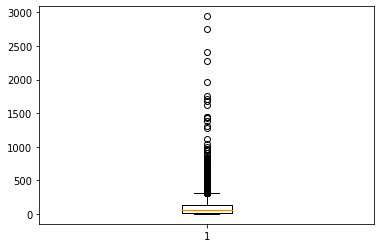

54.09
116.53852257781647


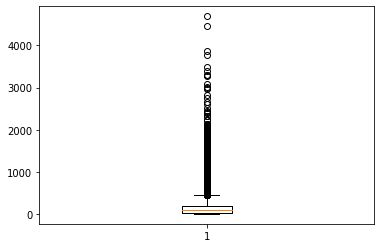

89.685
156.333575746402


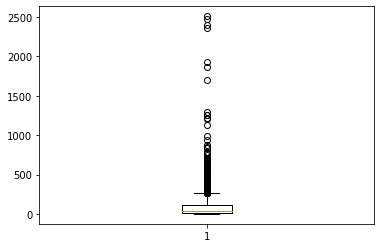

41.84
93.59543938711109


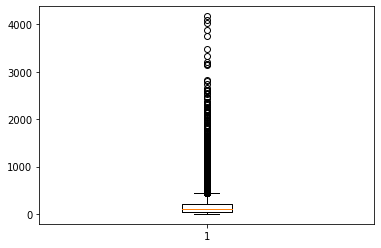

93.24
159.4435822486911


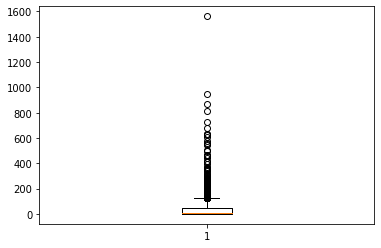

8.01
44.39848170731709


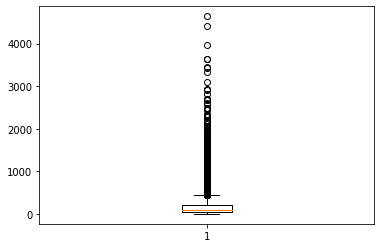

91.79
158.7792207361514


In [474]:
attributes = ['loc_ic_t2m_mou_6','loc_ic_t2m_mou_7','loc_ic_t2m_mou_8']
BoxPlot(churn_dataset_filtered_train,attributes)

In [475]:
churn_dataset_filtered_train = ImputeMedian(churn_dataset_filtered_train,attributes)

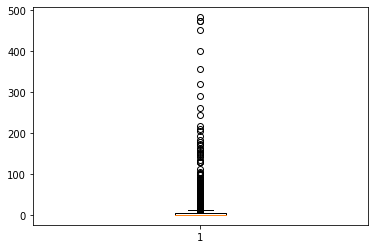

0.23
8.812415607189823


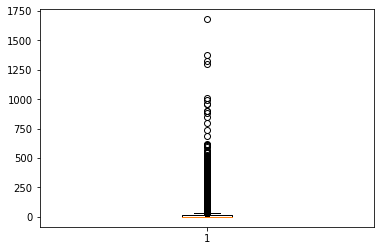

2.23
16.1419760412829


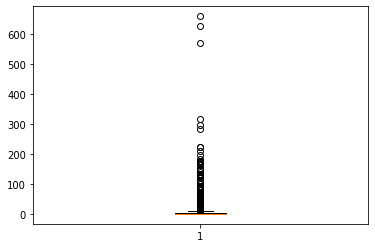

0.0
7.931099594411886


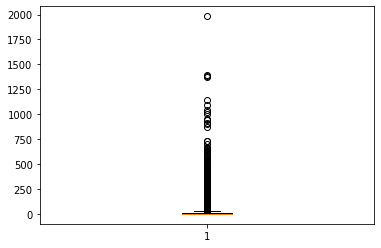

2.49
17.02478564600363


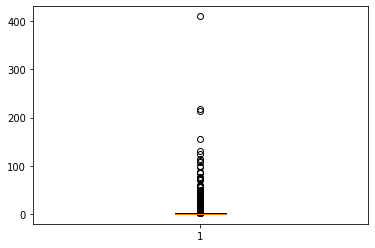

0.0
3.788353658536587


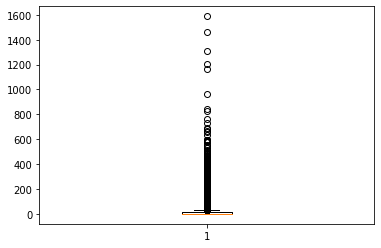

2.36
15.679451383515921


In [476]:
attributes = ['loc_ic_t2f_mou_6','loc_ic_t2f_mou_7','loc_ic_t2f_mou_8']
BoxPlot(churn_dataset_filtered_train,attributes)

In [477]:
churn_dataset_filtered_train = ImputeMedian(churn_dataset_filtered_train,attributes)

In [478]:
#These attributes are redundant,they can be dropped as already the individual category values are present
attributes = ['loc_ic_mou_6','loc_ic_mou_7','loc_ic_mou_8']
churn_dataset_filtered_train = churn_dataset_filtered_train.drop(attributes,axis = 1)

In [479]:
churn_dataset_filtered_train.shape

(29953, 143)

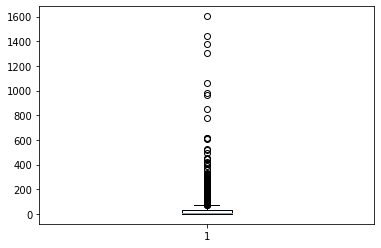

8.04
33.36111793073215


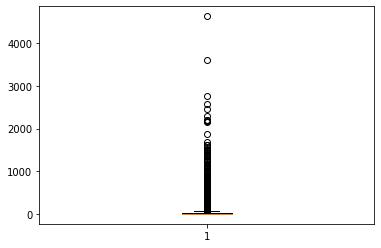

5.16
29.447244747512862


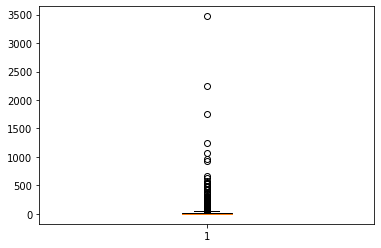

4.58
28.984407390716544


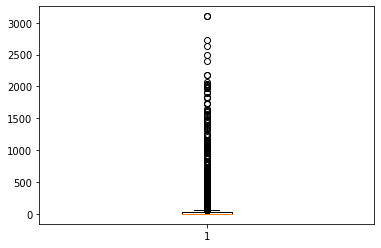

5.63
31.586333186264824


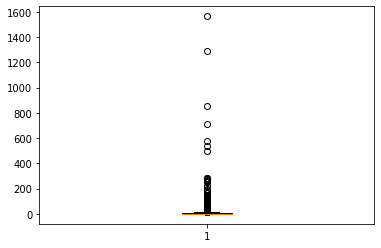

0.0
13.90778048780491


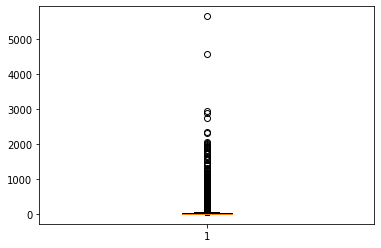

4.91
29.972726870786857


In [480]:
attributes = ['std_ic_t2m_mou_6','std_ic_t2m_mou_7','std_ic_t2m_mou_8']
BoxPlot(churn_dataset_filtered_train,attributes)

In [481]:
#Again these columns can be included imputed with their median as data is skewed.
churn_dataset_filtered_train = ImputeMedian(churn_dataset_filtered_train,attributes)

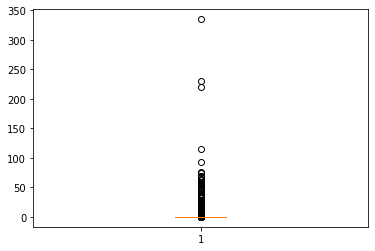

0.0
1.7975098640946976


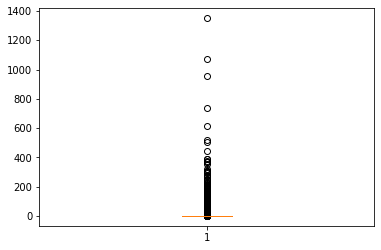

0.0
2.828525985993375


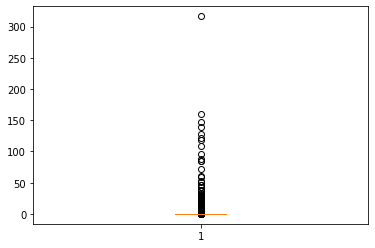

0.0
1.7184767913474543


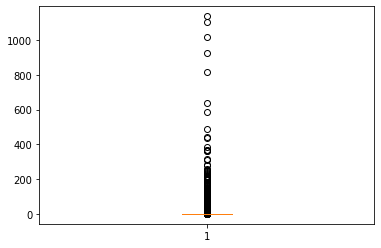

0.0
2.945424663578222


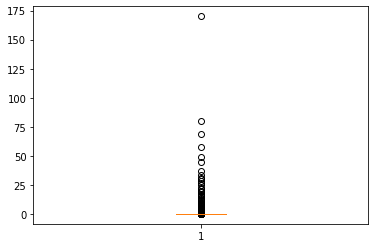

0.0
0.7087439024390245


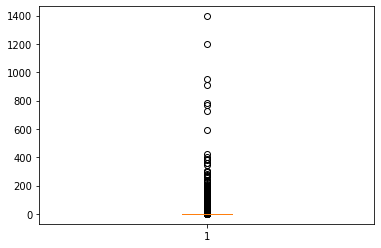

0.0
2.7878648539110658


In [482]:
attributes = ['std_ic_t2f_mou_6','std_ic_t2f_mou_7','std_ic_t2f_mou_8']
BoxPlot(churn_dataset_filtered_train,attributes)

Indeed there differences in distributions of 2 groups of churn and non churn.We can impute them with corresponding medians
to treat Nas

In [483]:
churn_dataset_filtered_train = ImputeMedian(churn_dataset_filtered_train,attributes)

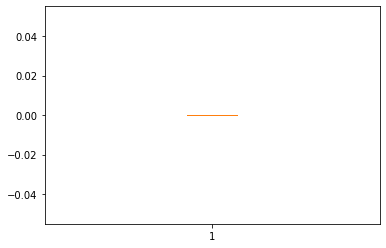

0.0
0.0


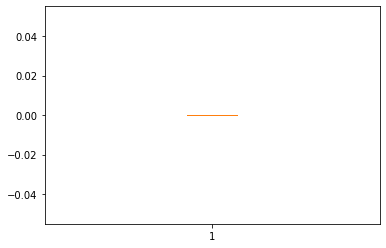

0.0
0.0


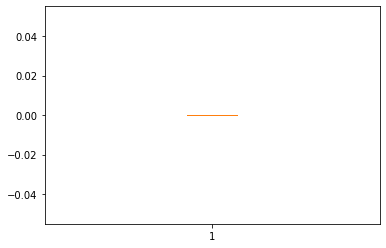

0.0
0.0


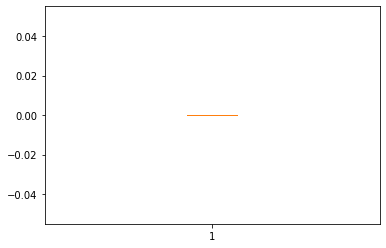

0.0
0.0


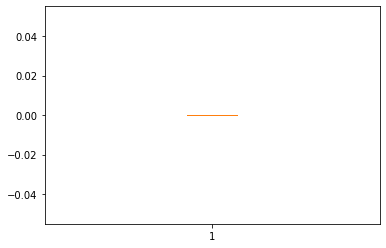

0.0
0.0


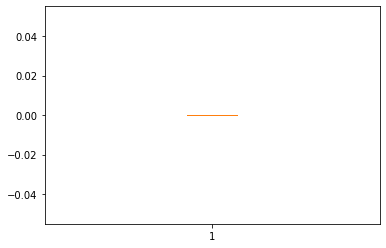

0.0
0.0


In [484]:
attributes = ['std_ic_t2o_mou_6','std_ic_t2o_mou_7','std_ic_t2o_mou_8']
BoxPlot(churn_dataset_filtered_train,attributes)

In [485]:
#All the value in case of std to other operator fixed line are 0.They can be dropped safely
churn_dataset_filtered_train = churn_dataset_filtered_train.drop(['std_ic_t2o_mou_6','std_ic_t2o_mou_7','std_ic_t2o_mou_8'],axis = 1)

In [486]:
# The total attributes which can be dropped are
attributes = ['std_ic_mou_6','std_ic_mou_7','std_ic_mou_8','total_ic_mou_6','total_ic_mou_7','total_ic_mou_8']
churn_dataset_filtered_train = churn_dataset_filtered_train.drop(attributes,axis =1)

In [487]:
churn_dataset_filtered_train.shape

(29953, 134)

In [488]:
#Special incomming calls can be dropped the way special outgoing calls were
attributes = ['spl_ic_mou_6','spl_ic_mou_7','spl_ic_mou_8']
churn_dataset_filtered_train = churn_dataset_filtered_train.drop(attributes,axis =1)

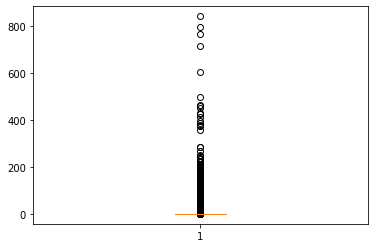

0.0
12.622170100832971


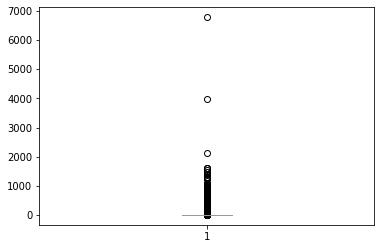

0.0
10.86366236638408


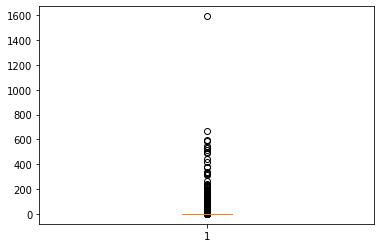

0.0
11.309260928346097


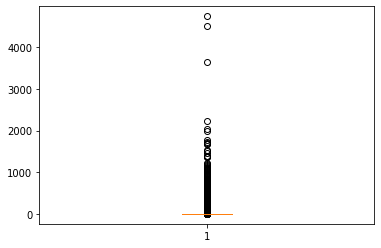

0.0
12.175222442826636


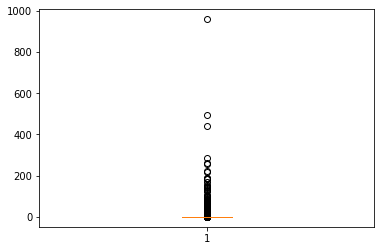

0.0
5.835810975609756


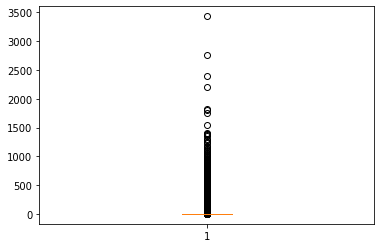

0.0
11.803669724770643


In [489]:
attributes = ['isd_ic_mou_6','isd_ic_mou_7','isd_ic_mou_8']
BoxPlot(churn_dataset_filtered_train,attributes)

In [490]:
#There are differences in both mean  of the groups.So possible incoming isd calls should be an attribute
#for seperation between classes.However the data is highly skewed so so median vallues can be used for impution
churn_dataset_filtered_train = ImputeMedian(churn_dataset_filtered_train,attributes)

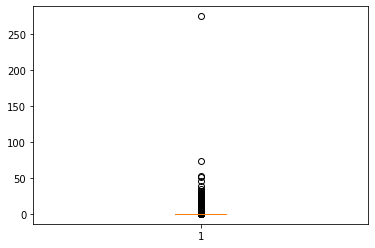

0.0
0.9726260412099967


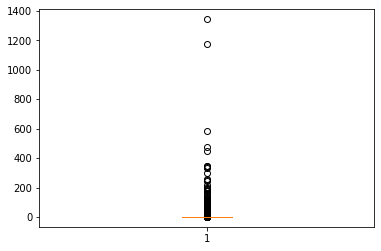

0.0
1.1936538886841215


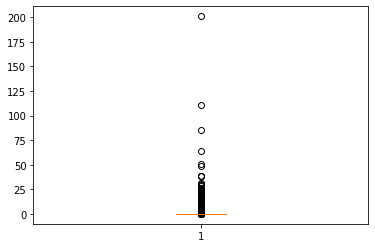

0.0
0.9192609283461007


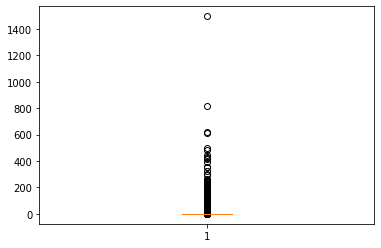

0.0
1.578923817927805


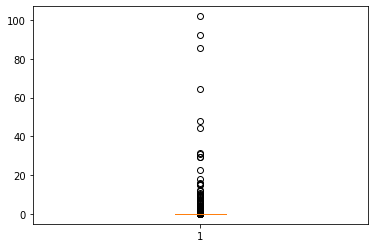

0.0
0.5951646341463417


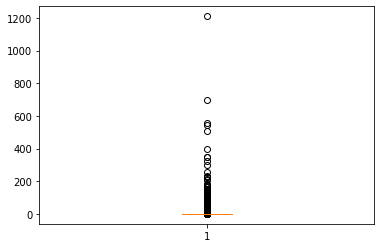

0.0
1.3172440219594108


In [491]:
#Finally with regard to call minutes lets look at other incoming calls
attributes = ['ic_others_6','ic_others_7','ic_others_8']
BoxPlot(churn_dataset_filtered_train,attributes)

In [492]:
#There are some differences in distributions atleast with regard to extreme values
#Its good to retain them ,they seem to be highly skewed ,so they can be imputed by median
churn_dataset_filtered_train = ImputeMedian(churn_dataset_filtered_train,attributes)

We can impute the total recharge num as it has erronous data ,for instance some rows indicate that even though
the recharge amount is positive for a month the value for number times of recharge is 0 and vice versa the number of times recharged is positive even though the recharge amount is 0.We can impute the value corresponding to 0 recharge amount with 0 times recharged.

In [493]:
churn_dataset_filtered_train.loc[churn_dataset_filtered_train['total_rech_amt_6'] ==0,'total_rech_num_6'] = 0
churn_dataset_filtered_train.loc[churn_dataset_filtered_train['total_rech_amt_7'] ==0,'total_rech_num_7'] = 0
churn_dataset_filtered_train.loc[churn_dataset_filtered_train['total_rech_amt_8'] ==0,'total_rech_num_8'] = 0

In [494]:
print(sum(churn_dataset_filtered_train['total_rech_amt_6'].isna()))
print(sum(churn_dataset_filtered_train['total_rech_amt_7'].isna()))
print(sum(churn_dataset_filtered_train['total_rech_amt_8'].isna()))
print(sum(churn_dataset_filtered_train['total_rech_num_6'].isna()))
print(sum(churn_dataset_filtered_train['total_rech_num_7'].isna()))
print(sum(churn_dataset_filtered_train['total_rech_num_8'].isna()))

0
0
0
0
0
0


Total recharge does not have any na or invalid values ,neither does total number of recharge

We can drop the columns corressponding to max_recharge_6,max_recharge_7,max_recharge_8 as the overall amount of recharge is
of significance ,not maximum recharge.

In [495]:
churn_dataset_filtered_train = churn_dataset_filtered_train.drop(['max_rech_amt_6','max_rech_amt_7','max_rech_amt_8'],axis = 1)

Similarly last recharge day and last recharge dates columns can be dropped as it does quite serve any business value

In [496]:
churn_dataset_filtered_train = churn_dataset_filtered_train.drop(['last_day_rch_amt_6','last_day_rch_amt_7','last_day_rch_amt_8'],axis = 1)

In [497]:
churn_dataset_filtered_train = churn_dataset_filtered_train.drop(['date_of_last_rech_data_6','date_of_last_rech_data_7','date_of_last_rech_data_8'],axis = 1)

Now lets look at the columns with high missing percentage

In [498]:
percent_missing = churn_dataset_filtered_train.isnull().sum() * 100 / len(churn_dataset_filtered_train)
missing_value_df = pd.DataFrame({'column_name': churn_dataset_filtered_train.columns,'percent_missing': percent_missing})

In [499]:
missing_value_df.loc[(missing_value_df['percent_missing'] >40),['column_name','percent_missing']]

,column_name,percent_missing
total_rech_data_6,total_rech_data_6,44.112443
total_rech_data_7,total_rech_data_7,43.117551
total_rech_data_8,total_rech_data_8,46.799987
max_rech_data_6,max_rech_data_6,44.112443
max_rech_data_7,max_rech_data_7,43.117551
max_rech_data_8,max_rech_data_8,46.799987
night_pck_user_6,night_pck_user_6,44.112443
night_pck_user_7,night_pck_user_7,43.117551
night_pck_user_8,night_pck_user_8,46.799987
fb_user_6,fb_user_6,44.112443


We can drop all the variables like total_rech_data_6,7,8 as we have new columns for it.We imputed right in the beginning for average recharge which determines it.Also max_rech_data 6,7,8 serves no purpose as total recharge is much more significant.

In [500]:
attributes = ['total_rech_data_6','total_rech_data_7','total_rech_data_8','max_rech_data_6','max_rech_data_7','max_rech_data_8']
churn_dataset_filtered_train = churn_dataset_filtered_train.drop(attributes,axis = 1)

In [501]:
churn_dataset_filtered_train.shape

(29953, 116)

In [502]:
percent_missing = churn_dataset_filtered_train.isnull().sum() * 100 / len(churn_dataset_filtered_train)
missing_value_df = pd.DataFrame({'column_name': churn_dataset_filtered_train.columns,'percent_missing': percent_missing})
missing_value_df.loc[(missing_value_df['percent_missing'] >40),['column_name','percent_missing']]

,column_name,percent_missing
night_pck_user_6,night_pck_user_6,44.112443
night_pck_user_7,night_pck_user_7,43.117551
night_pck_user_8,night_pck_user_8,46.799987
fb_user_6,fb_user_6,44.112443
fb_user_7,fb_user_7,43.117551
fb_user_8,fb_user_8,46.799987


In [503]:
churn_dataset_filtered_train = churn_dataset_filtered_train.drop(['night_pck_user_6','night_pck_user_7','night_pck_user_8','fb_user_6','fb_user_7','fb_user_8'],axis = 1)

In [504]:
#We can drop date_of_last_rech_8 and std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8 as they are already being handle by 
#individual months
churn_dataset_filtered_train = churn_dataset_filtered_train.drop(['date_of_last_rech_8','std_og_mou_6','std_og_mou_7','std_og_mou_8'],axis = 1)

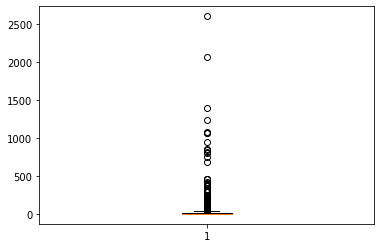

1.6
22.53370889960551


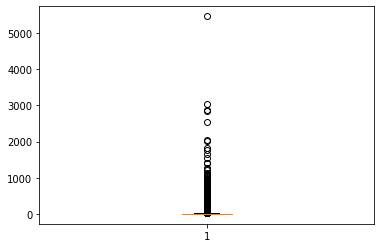

0.41
14.552355694802914


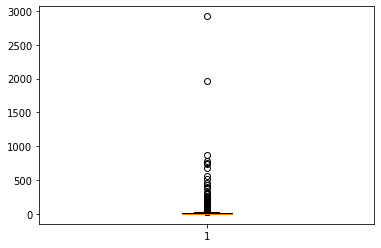

0.96
17.346611086074848


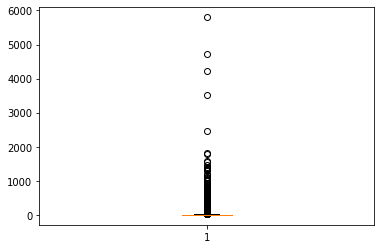

0.51
15.580839032281956


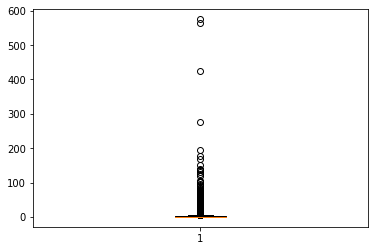

0.0
6.839603658536587


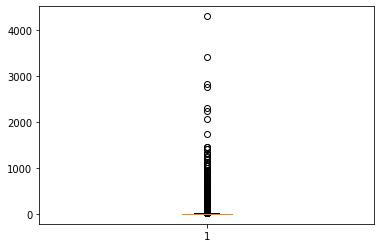

0.38
14.94874580892391


In [505]:
# We can analyze incomming std calls
attributes = ['std_ic_t2t_mou_6','std_ic_t2t_mou_7','std_ic_t2t_mou_8']
BoxPlot(churn_dataset_filtered_train,attributes)
#churn_dataset_filtered_train = ImputeMedian(churn_dataset_filtered_train,attributes)

In [506]:
#We can retain these attributes and impute by their median of respective classes
churn_dataset_filtered_train = ImputeMedian(churn_dataset_filtered_train,attributes)

We can as well drop off the variables onnet,offnet as they are the total of incomming and outgoing calls as they are 
already taken care by rest of the variables

In [507]:
churn_dataset_filtered_train = churn_dataset_filtered_train.drop(['onnet_mou_6','onnet_mou_7','onnet_mou_8','offnet_mou_6','offnet_mou_7','offnet_mou_8'],axis =1 )

Now lets analyze the final two types of variables roaming incoming calls and roaming outgoing calls.

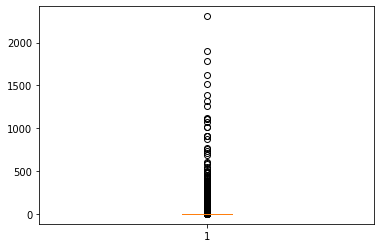

0.0
30.972700569925458


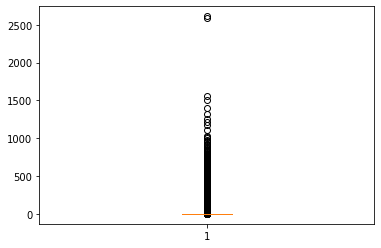

0.0
15.197695171397033


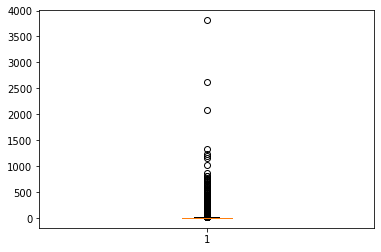

0.0
32.869914375844964


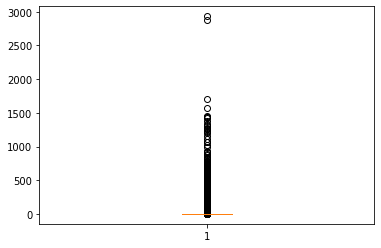

0.0
11.245372086182822


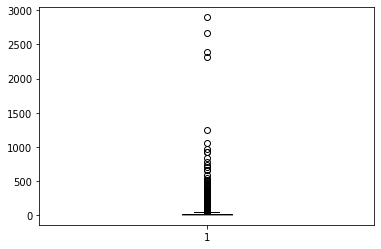

1.56
40.474018292682935


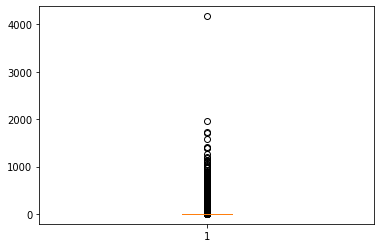

0.0
11.362978888029174


In [508]:
attributes = ['roam_ic_mou_6','roam_ic_mou_7','roam_ic_mou_8']
BoxPlot(churn_dataset_filtered_train,attributes)

We see that the churners have higher mean and the differences in distribution for both churners and non churners

In [509]:
attributes = ['roam_ic_mou_6','roam_ic_mou_7','roam_ic_mou_8']
churn_dataset_filtered_train = ImputeMedian(churn_dataset_filtered_train,attributes)

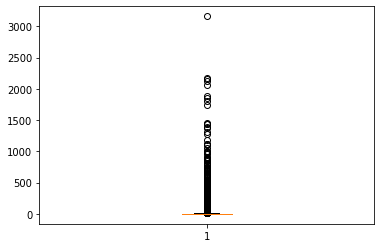

0.0
55.426926786497155


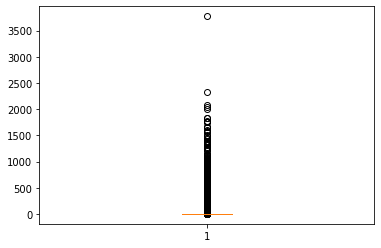

0.0
24.703360486546366


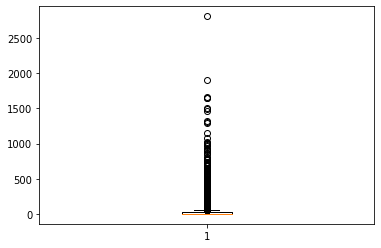

0.0
55.018499324019736


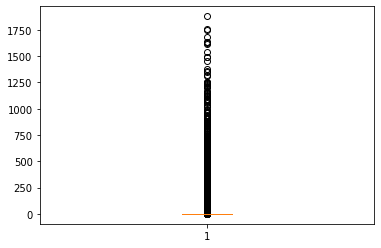

0.0
17.707944701816363


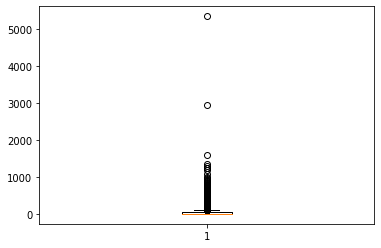

3.995
64.87507317073171


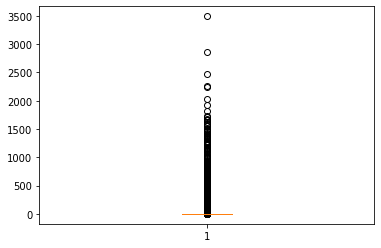

0.0
18.029878044287347


In [510]:
attributes = ['roam_og_mou_6','roam_og_mou_7','roam_og_mou_8']
BoxPlot(churn_dataset_filtered_train,attributes)

In [511]:
churn_dataset_filtered_train = ImputeMedian(churn_dataset_filtered_train,attributes)

In [512]:
percent_missing = churn_dataset_filtered_train.isna().sum() * 100 / len(churn_dataset_filtered_train)
missing_value_df = pd.DataFrame({'column_name': churn_dataset_filtered_train.columns,'percent_missing': percent_missing})
missing_value_df.loc[(missing_value_df['percent_missing'] >0),['column_name','percent_missing']]

,column_name,percent_missing


In [513]:
print(sum(churn_dataset_filtered_train.isna().sum()))
churn_dataset_filtered_train.shape

0


(29953, 100)

So finally the data is clean we not have any missing values and useful columns are retained

Now we can do some outlier treatment

First we check if the coulmns which are not strictly float have outliers or not.The outlier is defined as any observation which
is more than 2 stardard deviation away from mean.We take this instead of percentile because many values would be zero even at high percentiles.The lower bound is ignored as all the columns will have lower bounds close to 0 ,practically in real time.So it cannot be considered as outlier.

In [514]:
new_columns = churn_dataset_filtered_train.columns
strictly_float = []
for i in new_columns:
     c = list(filter(lambda x:isStrictlyFloat(str(x)),churn_dataset_filtered_train[i]))
     if len(c)>0:
        strictly_float.append(i)

In [515]:
len(strictly_float)

79

In [516]:
t = list(filter(lambda x:(x not in strictly_float),new_columns))

In [517]:
df_ints = churn_dataset_filtered_train[t]
#print(df_ints.describe())
low_max = []
for i in t:
     if max(df_ints[i]) > 2*np.std(df_ints[i])+np.mean(df_ints[i]):
       low_max.append(i) 
print(low_max)
print(len(low_max))

['total_rech_num_6', 'total_rech_num_7', 'total_rech_num_8', 'total_rech_amt_6', 'total_rech_amt_7', 'total_rech_amt_8', 'monthly_2g_6', 'monthly_2g_7', 'monthly_2g_8', 'sachet_2g_6', 'sachet_2g_7', 'sachet_2g_8', 'monthly_3g_6', 'monthly_3g_7', 'monthly_3g_8', 'sachet_3g_6', 'sachet_3g_7', 'sachet_3g_8', 'aon', 'churn']
20


In [518]:
#uniquevals_newcols = list(filter(lambda x:len(churn_dataset_filtered_train[x].unique)>0,new_columns))
#print(len(uniquevals_newcols))
print(t)
uniquevals_newcols = list(map(lambda x:len(churn_dataset_filtered_train[x].unique()),t))

['circle_id', 'total_rech_num_6', 'total_rech_num_7', 'total_rech_num_8', 'total_rech_amt_6', 'total_rech_amt_7', 'total_rech_amt_8', 'monthly_2g_6', 'monthly_2g_7', 'monthly_2g_8', 'sachet_2g_6', 'sachet_2g_7', 'sachet_2g_8', 'monthly_3g_6', 'monthly_3g_7', 'monthly_3g_8', 'sachet_3g_6', 'sachet_3g_7', 'sachet_3g_8', 'aon', 'churn']


In [519]:
uniquevals_newcols

[1,
 102,
 101,
 96,
 2298,
 2316,
 2304,
 5,
 6,
 6,
 31,
 35,
 34,
 12,
 15,
 12,
 25,
 27,
 29,
 3294,
 2]

Here we see all the columns which havve some or other integer values have outliers more than 2 standard deviations away.We can leave aside churn column and circle id.None of them are categorical,they have atleast 5 integral values

For outlier treatment first lets get the mean and standard deviation of each of the numeric columns dropping churn and 
circle_id.As the circle_id is categorical varaible so it cannot have outliers.

In [520]:
churn = churn_dataset_filtered_train['churn']
circle_id = churn_dataset_filtered_train['circle_id']
back_churndataset = churn_dataset_filtered_train
churn_dataset_filtered_train = churn_dataset_filtered_train.drop(['circle_id','churn'],axis = 1)
#churn_dataset_filtered_train.columns

We can drop the outliers that are more than 2 standard deviations away from mean of each column


In [521]:
indexes_tobedropped = remove_Outliers(churn_dataset_filtered_train)


In [522]:
print(len(indexes_tobedropped))

988


In [400]:
churn_dataset_filtered_train = back_churndataset
back_churn_2 = churn_dataset_filtered_train

In [401]:
print(churn_dataset_filtered_train.shape)

(29953, 94)


In [526]:
cf2 = churn_dataset_filtered_train.drop(churn_dataset_filtered_train.index[indexes_tobedropped])

In [527]:
cf2.shape
cf3 = cf2
cf3.columns
print(cf3.shape)

(28965, 98)


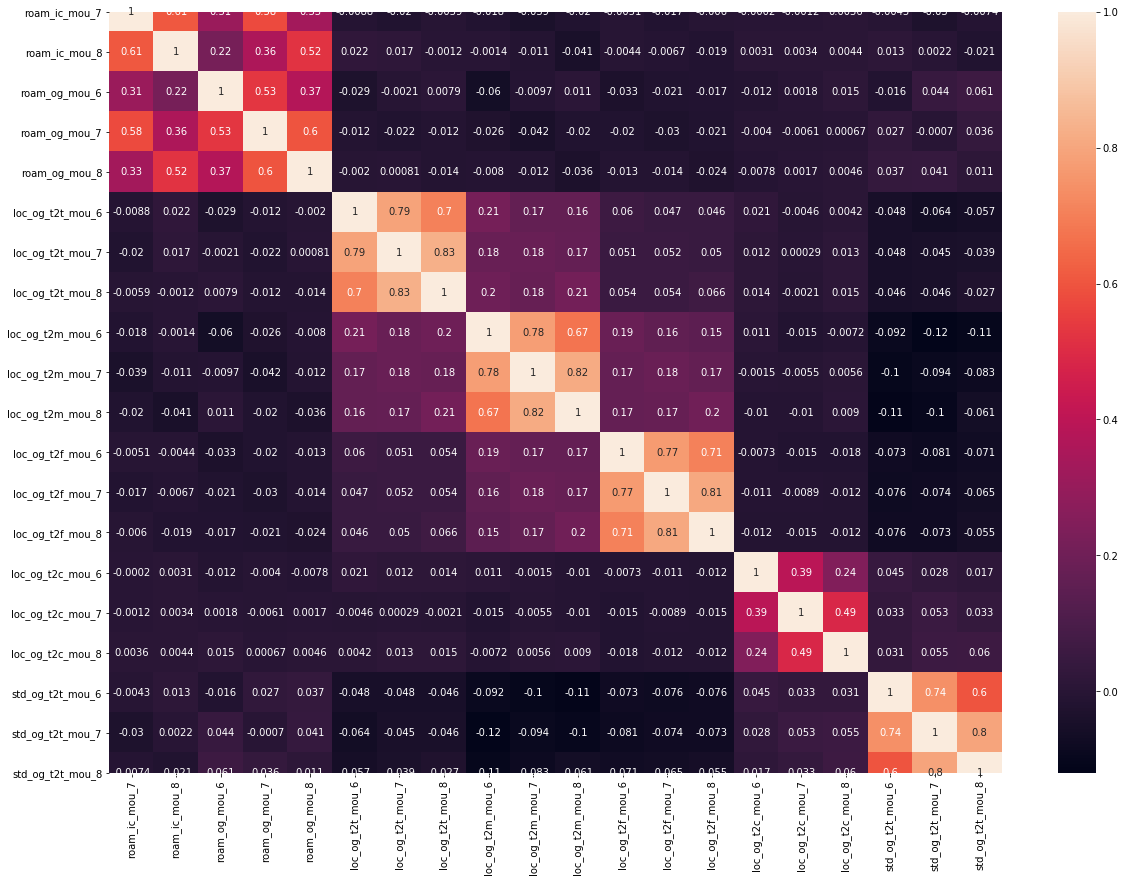

In [539]:
#Now lets view the correlation plots
import seaborn as sns
plt.figure(figsize=(20, 14))
corr = cf3[cf3.columns[1:21]].corr()
sns.heatmap(corr,annot=True)

The observations are that the roaming 6,7,8 months have good correlation with each other.The roaming outgoing and 
roaming incoming months.Seondly local outgoing mobile to mobile with same operators have good correlations.And local outgoing
mobile to other perators have correrations among months.Local outgoing from mobile to fixed lines  have correlations between months
Std outgoing with months have correrations

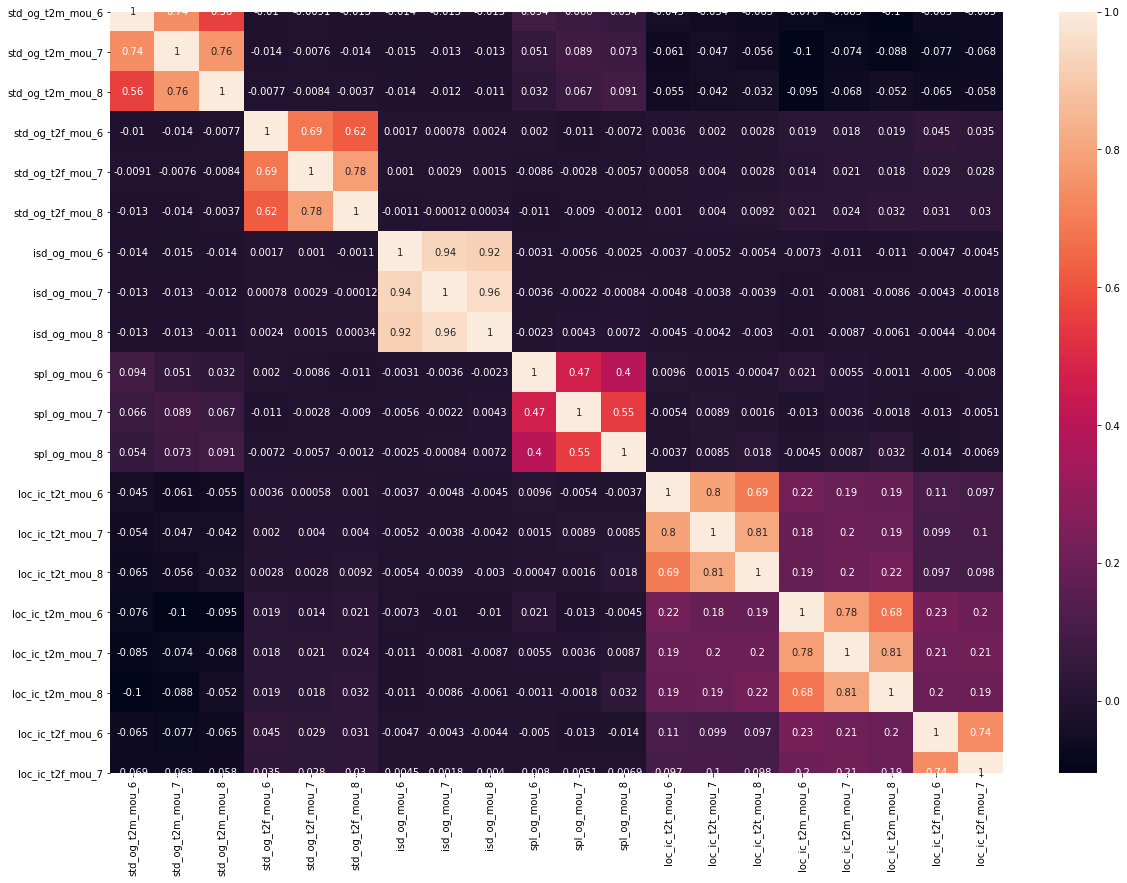

In [541]:
import seaborn as sns
plt.figure(figsize=(20, 14))
corr = cf3[cf3.columns[21:41]].corr()
sns.heatmap(corr,annot=True)

The std outgoing to other mobile operators are correration among months.Std outgoing to fixed lines are correlated.Isd outgoing
are also correlated within the 6,7,8 months.The special calls are also correrated among months.Local incoming calls within the same operator and incoming calls to different operators are also correlated.Local incoming calls to fixed lines are correlated

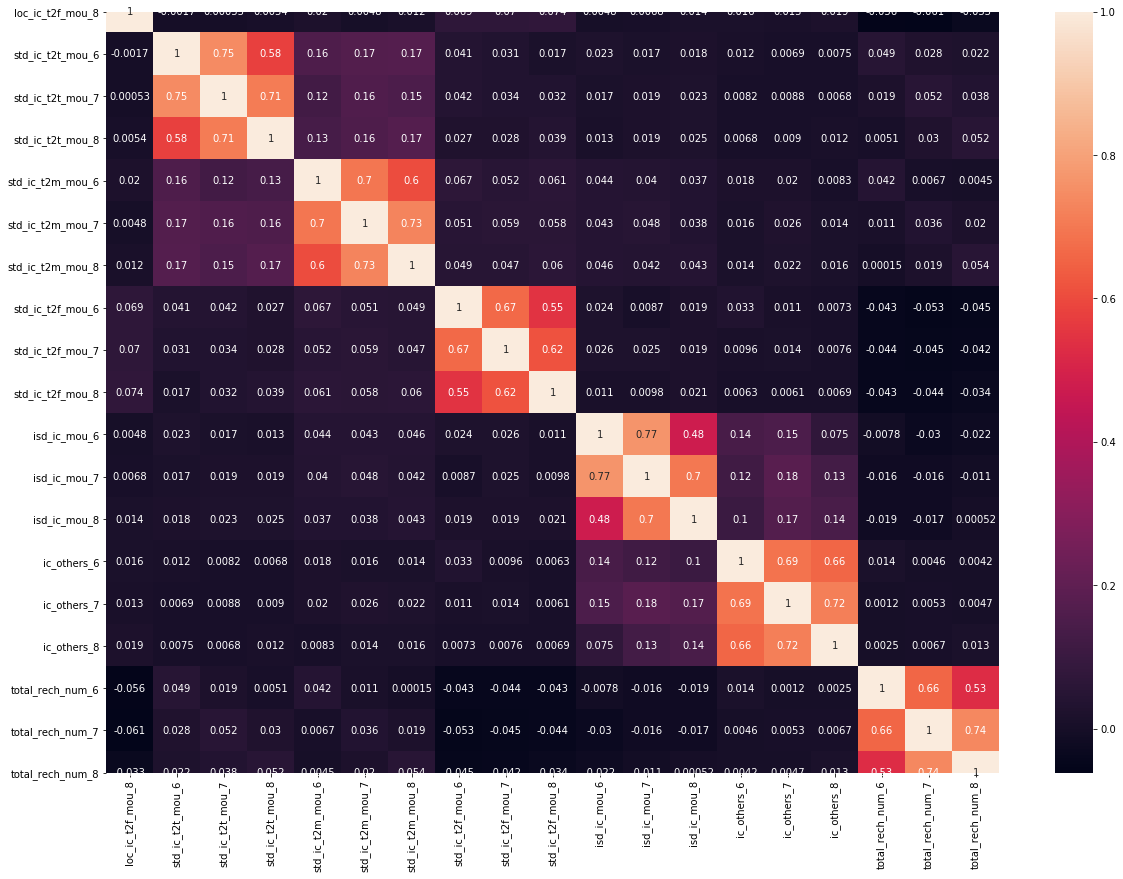

In [542]:
plt.figure(figsize=(20, 14))
corr = cf3[cf3.columns[41:60]].corr()
sns.heatmap(corr,annot=True)

All the std incomming calls within same mobile operators for different months are correrated.Same goes with different mobile operators
and even fixed lines too.Isd incomming calls are also correlated.The other calls are also correlated within months.
The number of times of recharge too has good correlation

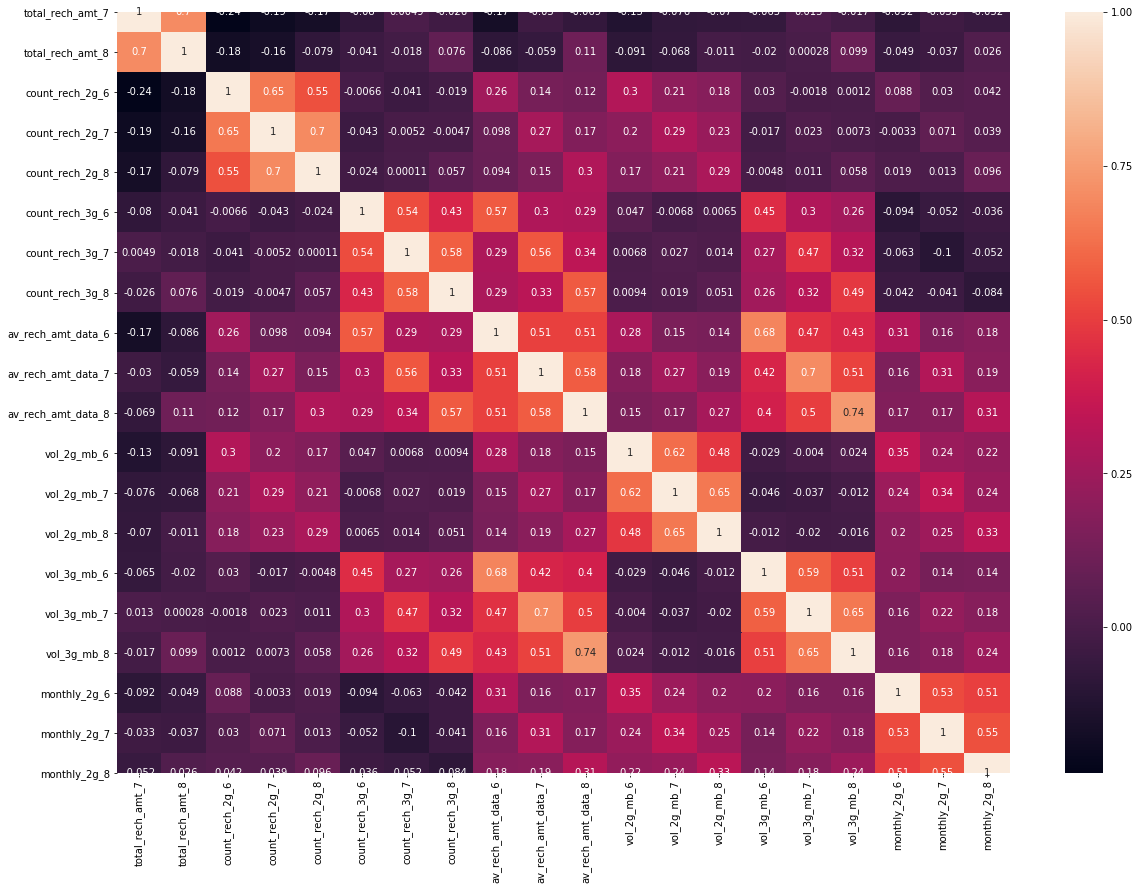

In [543]:
plt.figure(figsize=(20, 14))
corr = cf3[cf3.columns[61:81]].corr()
sns.heatmap(corr,annot=True)

There is quite a lot of correlation here.Total recharge amounts are correrated amonth the months.The counts of recharge amount are
also correrated among months.The same applues with av_rech_amt for data and volume of 2g .They all are correlated among their months
Vol 3g and monthly 2g are too correlated among months

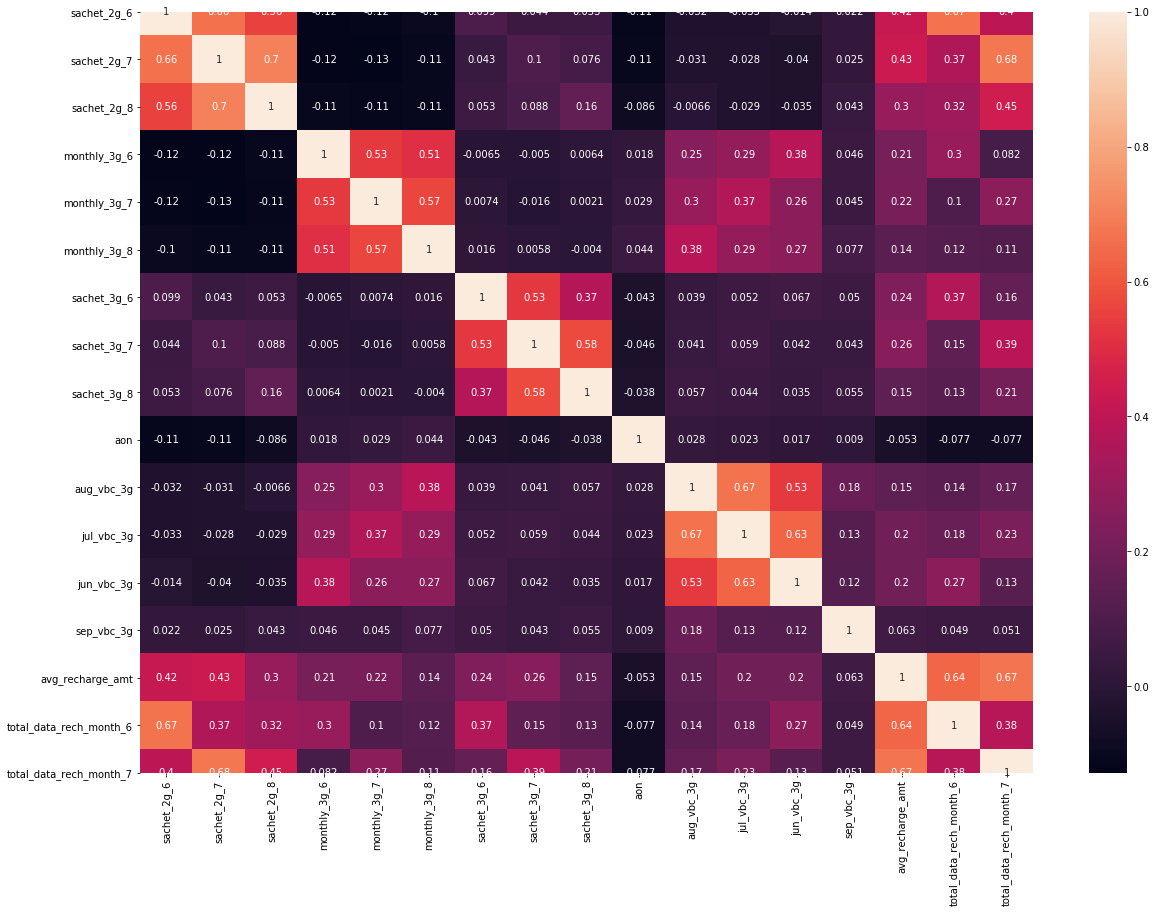

In [544]:
plt.figure(figsize=(20, 14))
corr = cf3[cf3.columns[81:]].corr()
sns.heatmap(corr,annot=True)

Sachet 2 g columns and monthly 3g columns are correlated among months.vbc_3g are too correlated amonth months  

Now we can dervive some new feature.Firstly the difference between the average recharge talktime amount of 6 and 7 months and talktime
amount of month 8

In [548]:
cf3['total_data_rech_month_8'] = (cf3['count_rech_2g_8']+cf3['count_rech_3g_8'])*cf3['av_rech_amt_data_8']

In [549]:
cf3['derive_diff_tktime_67n8'] = (cf3['total_rech_amt_6']+cf3['total_rech_amt_7'])/2 -cf3['total_rech_amt_8']
cf3['derive_diff_data_67n8'] = (cf3['total_data_rech_month_6']+cf3['total_data_rech_month_7'])/2 -cf3['total_data_rech_month_8']

The difference in  the average number of normal talktime recharges of months 6 and 7 versus recharge of month 8.
Also the differnce in the average number of data recharges of months 6 and 7 versus the recharge of month 8 

In [550]:
cf3['derive_diff_tktime_count_67n8'] = (cf3['total_rech_num_6']+cf3['total_rech_num_7'])/2 -cf3['total_rech_num_8']
cf3['derive_diff_data_count_67n8'] = (cf3['count_rech_2g_6']+cf3['count_rech_3g_6']+cf3['count_rech_2g_7']+cf3['count_rech_3g_7'])/2 -(cf3['count_rech_2g_8']+cf3['count_rech_3g_8'])

In [576]:
#Just appending back churn  coulmn for train test split
cf3['churn'] = churn
churn_dataset_filtered_train,churn_dataset_filtered_test=train_test_split(cf3,train_size=0.7,test_size=0.3,random_state=100)
#churn_dataset_filtered_train = churn_dataset_filtered_3

In [577]:
churn_train = churn_dataset_filtered_train['churn']
churn_dataset_filtered_train.drop('churn',axis = 1)
churn_test = churn_dataset_filtered_test['churn']
churn_dataset_filtered_test.drop('churn',axis = 1)
print("done")

done


In [578]:
scaler = preprocessing.StandardScaler()
churn_dataset_filtered_train[churn_dataset_filtered_train.columns] = scaler.fit_transform(churn_dataset_filtered_train[churn_dataset_filtered_train.columns])

C:\Users\Jabir_shabbir\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Jabir_shabbir\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [579]:
#churn_dataset_filtered_train.head()
np.mean(churn_dataset_filtered_train['roam_ic_mou_6'])

-1.0043151404363766e-15

In [580]:
churn_dataset_filtered_train['churn'] = churn_train
#churn_dataset_filtered_train = churn_dataset_filtered_train.drop(['circle_id'],axis = 1)

C:\Users\Jabir_shabbir\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [581]:
churn_dataset_filtered_test[churn_dataset_filtered_test.columns] = scaler.transform(churn_dataset_filtered_test[churn_dataset_filtered_test.columns])

C:\Users\Jabir_shabbir\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\Jabir_shabbir\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [582]:
#churn_dataset_filtered_test = churn_dataset_filtered_test.drop(['circle_id'],axis = 1)
churn_dataset_filtered_test['churn'] = churn_test

C:\Users\Jabir_shabbir\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [584]:
print(churn_dataset_filtered_train.shape)
print(churn_dataset_filtered_test.shape)
np.mean(churn_dataset_filtered_test['roam_ic_mou_6'])

(20275, 104)
(8690, 104)


-0.0013837264145161263

In [585]:
churn_dataset_filtered_train.to_csv('traindata.csv')
churn_dataset_filtered_test.to_csv('testdata.csv')

In [2]:
from sklearn.decomposition import IncrementalPCA
import seaborn as snb
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

In [3]:
def draw_roc( actual, predicted ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, predicted,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, predicted )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.show()

    return None

In [4]:
scaled_churn_data = pd.read_csv('traindata.csv')

In [5]:
#t = pd.read_csv('telecom_churn_data.csv')
scaled_churn_data['Unnamed: 0'].head()
scaled_churn_data = scaled_churn_data.drop(['Unnamed: 0'],axis = 1)

In [6]:
churn = scaled_churn_data['churn']
scaled_churn_data = scaled_churn_data.drop(['churn'],axis = 1)

In [7]:
from sklearn.decomposition import PCA
pca = PCA(svd_solver='randomized', random_state=42)
pca.fit(scaled_churn_data)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=42,
    svd_solver='randomized', tol=0.0, whiten=False)

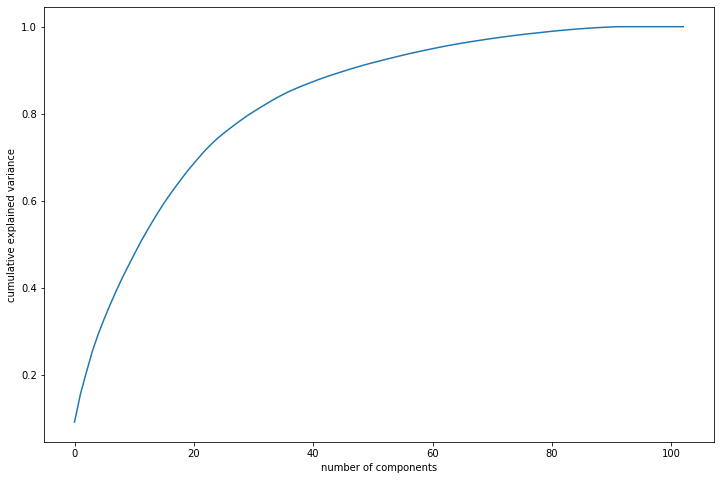

In [8]:
%matplotlib inline
fig = plt.figure(figsize = (12,8))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

In [9]:
np.cumsum(pca.explained_variance_ratio_)

array([0.09122821, 0.15585431, 0.20614399, 0.25442489, 0.29431749,
       0.32926866, 0.36194859, 0.39302162, 0.42256485, 0.44980395,
       0.47662353, 0.50302917, 0.52722384, 0.5505282 , 0.57309435,
       0.59457749, 0.6144174 , 0.63327827, 0.65172584, 0.66961507,
       0.68575301, 0.7017223 , 0.71732512, 0.73099866, 0.74379211,
       0.75507175, 0.76579993, 0.77611568, 0.78616552, 0.79586703,
       0.80460317, 0.81313462, 0.82144361, 0.82963089, 0.8373773 ,
       0.8445735 , 0.85132842, 0.85732411, 0.86310037, 0.86850446,
       0.87379804, 0.87905926, 0.88386415, 0.88845524, 0.89297409,
       0.897316  , 0.90164085, 0.90579606, 0.90984425, 0.91363224,
       0.91729169, 0.92083509, 0.92430156, 0.92771379, 0.93109514,
       0.9343922 , 0.93766195, 0.94078876, 0.94376057, 0.94663439,
       0.94945791, 0.95224753, 0.95499442, 0.95756642, 0.95995746,
       0.96231242, 0.96456767, 0.9667445 , 0.96885088, 0.97094511,
       0.97295512, 0.97487552, 0.97672847, 0.97855013, 0.98031

Here we see that 62 components are sufficient to explain 95% of the variance

In [10]:
#however we can take incremental PCA to get the values of data corresponding to new components
pca_final = IncrementalPCA(n_components=62)
churn_data_pca = pca_final.fit_transform(scaled_churn_data)
churn_data_pca.shape

(20275, 62)

In [11]:
correlation_mat = np.corrcoef(churn_data_pca.transpose())

In [12]:
corrmat_nodiag = correlation_mat - np.diagflat(correlation_mat.diagonal())
print(np.max(corrmat_nodiag))
print(np.min(corrmat_nodiag))
correlation_mat.shape

0.024476003343678703
-0.02668728713554947


(62, 62)

Here PCA has done well in getting rid of correlated components

Now comes the modelling part .Lets start on with Logistic Regression

In [13]:
#load test data
scaled_churn_data_test = pd.read_csv('testdata.csv')
churn_test = scaled_churn_data_test['churn']
scaled_churn_data_test = scaled_churn_data_test.drop(['churn'],axis = 1)

In [14]:
scaled_churn_data_test = scaled_churn_data_test.drop(['Unnamed: 0'],axis = 1)

In [15]:
churn_test_data = pca_final.transform(scaled_churn_data_test)

In [16]:
churn_test_data.shape

(8690, 62)

In [602]:
#To resolve the problem of class imbalance we can use balanced tag in the model as it increses the weightage of errors
#on negative points in loss function
learner_pca = LogisticRegression(random_state=0, class_weight='balanced')
model_pca = learner_pca.fit(churn_data_pca,churn)

C:\Users\Jabir_shabbir\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [605]:
#Now lets check the model on training data first with default cutt off of 0.5
pred_prob_train = model_pca.predict_proba(churn_data_pca)[:,1]
churn_pred = pd.Series(pred_prob_train).map(lambda x:1 if x>0.5 else 0)

In [606]:
# Let's take a look at the confusion matrix again 
confusion = metrics.confusion_matrix(churn,churn_pred )
confusion

array([[15009,  3605],
       [  291,  1370]], dtype=int64)

In [610]:
print(metrics.accuracy_score(churn, churn_pred))
print(metrics.recall_score(churn, churn_pred))
print(confusion[0,0]/(confusion[0,0]+confusion[0,1]))

0.8078421701602959
0.8248043347381095
0.8063285698936284


It has overall 80.7% accuracy with sensitivity being 82.4% and specificity being 80.6% 

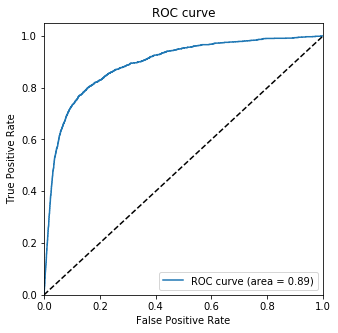

In [611]:
draw_roc(churn, pred_prob_train)

The roc curve is good with area being 0.89.It is a pretty decent model.However lets see if we can do better on sensitivity.
As predicting churn correctly is more critical than false prediction.

In [612]:
#Run in loop the various cuttoffs from 0.2 to 0.5 and choose the right set of metrics
for cutoff in [0.5,0.45,0.4,0.35,0.3,0.25,0.2]:
    churn_pred = pd.Series(pred_prob_train).map(lambda x:1 if x>cutoff else 0)
    confusion = metrics.confusion_matrix(churn,churn_pred )
    print(str(cutoff)+":")
    print(confusion)
    sensitivity = confusion[1,1]/(confusion[1,1]+confusion[1,0])
    specificity = confusion[0,0]/(confusion[0,0]+confusion[0,1])
    print("Sensitivity:")
    print(sensitivity)
    print("Specificity:")
    print(specificity)
    print("Accuracy")
    print(metrics.accuracy_score(churn, churn_pred))
    print("")

0.5:
[[15009  3605]
 [  291  1370]]
Sensitivity:
0.8248043347381095
Specificity:
0.8063285698936284
Accuracy
0.8078421701602959

0.45:
[[14288  4326]
 [  240  1421]]
Sensitivity:
0.8555087296809151
Specificity:
0.7675942838723542
Accuracy
0.7747965474722565

0.4:
[[13473  5141]
 [  203  1458]]
Sensitivity:
0.8777844671884407
Specificity:
0.7238100354571828
Accuracy
0.7364241676942047

0.35:
[[12608  6006]
 [  173  1488]]
Sensitivity:
0.8958458759783263
Specificity:
0.6773396368324917
Accuracy
0.6952404438964241

0.3:
[[11713  6901]
 [  145  1516]]
Sensitivity:
0.9127031908488862
Specificity:
0.6292575480820888
Accuracy
0.652478421701603

0.25:
[[10673  7941]
 [  108  1553]]
Sensitivity:
0.9349789283564118
Specificity:
0.5733856237240786
Accuracy
0.6030086313193588

0.2:
[[9511 9103]
 [  83 1578]]
Sensitivity:
0.9500301023479831
Specificity:
0.5109594928548404
Accuracy
0.5469297163995068



We see that sensitivity keeps increasing as cutt off drops.0.45 seems to be an optimal model for given set of cuttoffs as recall is 
quite high,however that comes at the price of specificity dropping to 76%.Increasing the cutt off further does not improve
sensitivity much but rather drops accuracy and specificity significantly

Now lets check the performance metrics on test data

In [616]:
pred_prob_test = model_pca.predict_proba(churn_test_data)[:,1]
churn_pred_test = pd.Series(pred_prob_test).map(lambda x:1 if x>=0.45 else 0)
confusion = metrics.confusion_matrix(churn_test,churn_pred_test )
print(confusion)
sensitivity = confusion[1,1]/(confusion[1,1]+confusion[1,0])
specificity = confusion[0,0]/(confusion[0,0]+confusion[0,1])
print("Sensitivity:")
print(sensitivity)
print("Specificity:")
print(specificity)
print("Accuracy")
print(metrics.accuracy_score(churn_test, churn_pred_test))

[[6077 1874]
 [ 107  632]]
Sensitivity:
0.8552097428958051
Specificity:
0.764306376556408
Accuracy
0.7720368239355581


The model seems to be doing good in a similar way on test data as well with good sensitivity score and model metrics are also
stable when compared to metrics on training data.There is no evidence of overfitting

Now lets build another model using SVms

In [617]:
svc_model = SVC(C=10,kernel = 'linear',class_weight='balanced')
svc_model.fit(churn_data_pca,churn)
pred_svm = svc_model.predict(churn_data_pca)

In [620]:
print(metrics.confusion_matrix(churn,pred_svm))
print(metrics.accuracy_score(churn, pred_svm))
print(metrics.recall_score(churn, pred_svm))

[[15404  3210]
 [  302  1359]]
0.8267817509247842
0.8181818181818182


In [622]:
pred_svm_test = svc_model.predict(churn_test_data)
print(metrics.accuracy_score(churn_test, pred_svm_test))
print(metrics.recall_score(churn_test, pred_svm_test))

0.8219792865362485
0.8092016238159675


SVM is providing accuracy of 82% and recall of 80.9%.The model also is stable and able to generalize since the test score 
is comparable to train score.However lets try grid search to see if anything better can be done

We can target gris seaarch to find optimal set of parameters.the scoring measure would be recall as sensitivity is important.
Though the model will fill find hyperplane which seperates the classes ,the one with highest recall we will consider.

In [ ]:
folds = KFold(n_splits = 5,shuffle = True,random_state = 4)
hyperparameters = {'gamma' :[0.001,0.01,0.05,0.1,0.5,10,100],'C':[1,1.5,2,2.5,4,5,6,8]}
model_svc = SVC(kernel = "rbf",class_weight='balanced')  
model_grid_search = GridSearchCV(estimator = model_svc,param_grid = hyperparameters,scoring = 'f1',cv = folds,verbose = 1,return_train_score = True,n_jobs = 5)
model_grid_search.fit(churn_data_pca,churn)

Fitting 5 folds for each of 56 candidates, totalling 280 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed: 35.3min
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed: 183.9min


In [ ]:
#First lets target accuracy and see how the model performs
folds = KFold(n_splits = 5,shuffle = True,random_state = 4)
hyperparameters = [{'gamma' :[0.001,0.01,0.05,0.1,0.5,10,30,50,100],'C':[10,15,20,25,30,50,100]}]
model_svc = SVC(kernel = "rbf",class_weight='balanced')  
model_grid_search = GridSearchCV(estimator = model_svc,param_grid = hyperparameters,scoring = 'accuracy',cv = folds,verbose = 1,return_train_score = True)
model_grid_search.fit(churn_data_pca,churn)

In [ ]:
model_summary = pd.DataFrame(model_grid_search.cv_results_)
print(model_summary)

In [ ]:
model_summary.to_csv('svm_model.csv')

In [ ]:
model_summary = pd.read_csv('svm_model.csv')
fig = plt.figure(figsize=(16,16))
fig.tight_layout()
gamma =[0.001,0.01,0.05,0.1,0.5,10,30,50,100]
count = 1
for i in gamma:
    gamma_filter = model_summary[model_summary['param_gamma'] == i]
    C_gamma = gamma_filter['params']
    #print(C_gamma)
    mps = list(map(lambda x:ast.literal_eval(x),C_gamma))
    Cs = list(map(lambda x:x['C'],mps))
    mean_test_score = list(gamma_filter['mean_test_score'])
    mean_train_score = list(gamma_filter['mean_train_score'])
    if count == 1:
        ax = fig.add_subplot(331)
        plt.title("Gamma=0.001")
    if count == 2:
        ax = fig.add_subplot(332)
        plt.title("Gamma=0.01")
    if count == 3:
        ax = fig.add_subplot(333)
        plt.title("Gamma=0.05")

    if count == 4:
        ax = fig.add_subplot(334)
        plt.title("Gamma=0.1")
    if count == 5:
        ax = fig.add_subplot(335)
        plt.title("Gamma=0.5")
    if count == 6:
        ax = fig.add_subplot(336)
        plt.title("Gamma=10")
    if count == 7:
        ax = fig.add_subplot(337)
        plt.title("Gamma=30")
    if count == 8:
        ax = fig.add_subplot(338)
        plt.title("Gamma=50")
    if count == 9:
        ax = fig.add_subplot(339)
        plt.title("Gamma=50")
    count = count+1
    ax.plot(Cs, mean_test_score)
    ax.plot(Cs, mean_train_score)
    plt.xlabel('C')
    plt.ylabel('Accuracy')
    plt.ylim([0.7, 1.1])
    plt.xlim([10,100])
#ax.legend(['test accuracy', 'train accuracy'], loc='upper left')

Here we see that only first plots have resonably stable model which does not overfit that is gamma = 0.001 and gamma = 0.01.However for
gamma =0.01 only at C = 10 the model is resonable good.for higher values of C the model seems to overfit

In [35]:
model_svc_rbf_1 = SVC(kernel = "rbf",class_weight='balanced',gamma =0.001,C=100)  
model_svc_rbf_1.fit(churn_data_pca,churn)

SVC(C=100, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [37]:
svm_model_poly_predict_test = model_svc_rbf_1.predict(churn_test_data)
print(metrics.confusion_matrix(churn_test,svm_model_poly_predict_test))
print(metrics.accuracy_score(churn_test,svm_model_poly_predict_test))
print(metrics.recall_score(churn_test,svm_model_poly_predict_test))

[[6879 1072]
 [ 166  573]]
0.8575373993095512
0.7753721244925575


With this model the accuracy is 85.7% and recall is 77%

#Lets check the other model where C = 10 and gamma = 0.01
model_svc_rbf_2 = SVC(kernel = "rbf",class_weight='balanced',gamma =0.01,C=10)  
model_svc_rbf_2.fit(churn_data_pca,churn)

In [40]:
svm_model_rbf_predict_train = model_svc_rbf_2.predict(churn_data_pca)
print(metrics.confusion_matrix(churn,svm_model_rbf_predict_train))
print(metrics.accuracy_score(churn,svm_model_rbf_predict_train))
print(metrics.recall_score(churn,svm_model_rbf_predict_train))

[[17230  1384]
 [   77  1584]]
0.927940813810111
0.9536423841059603


On train data the model seems to be doing really good on accuracy and recall however lets check on test data

In [39]:
svm_model_poly_predict_test = model_svc_rbf_2.predict(churn_test_data)
print(metrics.confusion_matrix(churn_test,svm_model_poly_predict_test))
print(metrics.accuracy_score(churn_test,svm_model_poly_predict_test))
print(metrics.recall_score(churn_test,svm_model_poly_predict_test))

[[7152  799]
 [ 244  495]]
0.8799769850402762
0.6698240866035182


This model is even worse in terms of recall.With increase in gamma the model performs poorly in terms of recall.Clearly the model is overfitting in terms of recall.The error margin is very low for both positive and negative classes and the model gets very specific to fit churn classes as it cannot generalize due to lack of data for churn claases

Lets perform another grid search targetting recall and check model performance.Ideally the gamma value has to be lower that is 0.001 and range of C values too will be lower as with higher values of gamma the model overfits in terms of accuracy.We can again perform grid search for lower values of C.

In [ ]:
folds = KFold(n_splits = 5,shuffle = True,random_state = 4)
hyperparameters = {'C':[1,1.5,2,2.5,4,5,6,8],'gamma':[0.001,0.01,0.1]}
model_svc = SVC(kernel = "rbf",class_weight='balanced')  
model_grid_search = GridSearchCV(estimator = model_svc,param_grid = hyperparameters,scoring = 'recall',cv = folds,verbose = 1,return_train_score = True,n_jobs=5)
model_grid_search.fit(churn_data_pca,churn)
res = pd.DataFrame(model_grid_search.cv_results_)
res.to_csv('RadialKernelSVMGridSearch_Recall.csv')

In [42]:
model_radial = pd.read_csv('RadialKernelSVMGridSearch_Recall.csv')

In the model summary we see that the model with best recall has the parameters gamma 0.001 and C = 1.5

In [46]:
model_svc_rbf_low_C = SVC(kernel = "rbf",class_weight='balanced',gamma =0.001,C=1.5)  
model_svc_rbf_low_C.fit(churn_data_pca,churn)

SVC(C=1.5, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [47]:
svm_model_rbf_predict_train = model_svc_rbf_low_C.predict(churn_data_pca)
print(metrics.confusion_matrix(churn,svm_model_rbf_predict_train))
print(metrics.accuracy_score(churn,svm_model_rbf_predict_train))
print(metrics.recall_score(churn,svm_model_rbf_predict_train))

[[15695  2919]
 [  306  1355]]
0.840937114673243
0.8157736303431667


This model seems to have good metric atleast on train dataset in terms of accuracy and recall.However lets check on test dataset

In [48]:
svm_model_poly_predict_test = model_svc_rbf_low_C.predict(churn_test_data)
print(metrics.confusion_matrix(churn_test,svm_model_poly_predict_test))
print(metrics.accuracy_score(churn_test,svm_model_poly_predict_test))
print(metrics.recall_score(churn_test,svm_model_poly_predict_test))

[[6675 1276]
 [ 147  592]]
0.8362485615650173
0.8010825439783491


So this model does have good performance on in terms of accuracy and recall on both train and test data.The model is pretty much 
stable.However many false positives are raised but anyway overall accuracy and recall is of major concern

Next lets try different model .We can try the random forest model as its the ensemble model.It captures diversity using different samples of data by bagging and different subset of features.

In [49]:
folds = KFold(n_splits = 5,shuffle = True,random_state = 4)
#hyperparameters = {'max_depth': [10,15,20,25,30,35,40,45,50],'min_samples_leaf':range(10,310,10),'n_estimators': range(50,750, 50),'max_features':range(10,45,5)}
hyperparameters = {'max_depth': [15,30,50],'min_samples_leaf':[30,150,300],'n_estimators': [50,140,80],'max_features':[5,25,50]}

In [ ]:
rf = RandomForestClassifier( bootstrap=True,class_weight='balanced')
grid_search = GridSearchCV(estimator = rf, param_grid = hyperparameters, 
                          cv = 5, n_jobs = 30,verbose = 1,scoring = 'recall',return_train_score = True)
grid_search.fit(churn_data_pca,churn)
res = pd.DataFrame(grid_search.cv_results_)
res.to_csv('RandomForestGridSearchResult_Recall.csv')

In [ ]:
rf_model = pd.read_csv('RandomForestGridSearchResult_Recall.csv')

In [52]:
rfc = RandomForestClassifier( bootstrap=True,class_weight='balanced',max_depth = 50,max_features = 25,min_samples_leaf = 300,n_estimators = 80)
rfc.fit(churn_data_pca,churn)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=50, max_features=25,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=300,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=80, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

In [53]:
predict_train = rfc.predict(churn_data_pca)
predict_test = rfc.predict(churn_test_data)

In [56]:
print(metrics.confusion_matrix(churn,predict_train))
print(metrics.accuracy_score(churn,predict_train))
print(metrics.recall_score(churn,predict_train))

[[15576  3038]
 [  363  1298]]
0.8322564734895191
0.7814569536423841


In [57]:
print(metrics.confusion_matrix(churn_test,predict_test))
print(metrics.accuracy_score(churn_test,predict_test))
print(metrics.recall_score(churn_test,predict_test))

[[6640 1311]
 [ 186  553]]
0.8277330264672037
0.7483085250338295


This has worsened the results compared to SVM.May be we can try different stragey for Grid Searchwith different parameters.

Lets tweak around some parameters to find the good model

In [59]:
rfc = RandomForestClassifier( bootstrap=True,class_weight='balanced',max_depth = 30,max_features = 5,min_samples_leaf = 30,n_estimators = 140)
rfc.fit(churn_data_pca,churn)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=30, max_features=5,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=30,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=140, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

In [60]:
print(metrics.confusion_matrix(churn,predict_train))
print(metrics.accuracy_score(churn,predict_train))
print(metrics.recall_score(churn,predict_train))

[[15576  3038]
 [  363  1298]]
0.8322564734895191
0.7814569536423841


In [61]:
print(metrics.confusion_matrix(churn_test,predict_test))
print(metrics.accuracy_score(churn_test,predict_test))
print(metrics.recall_score(churn_test,predict_test))

[[6640 1311]
 [ 186  553]]
0.8277330264672037
0.7483085250338295


In [72]:
rfc = RandomForestClassifier( bootstrap=True,class_weight='balanced',max_depth = 15,max_features = 40,min_samples_leaf = 400,n_estimators = 80)
rfc.fit(churn_data_pca,churn)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=15, max_features=40,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=400,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=80, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

In [63]:
predict_train = rfc.predict(churn_data_pca)
predict_test = rfc.predict(churn_test_data)

In [73]:
print(metrics.confusion_matrix(churn,predict_train))
print(metrics.accuracy_score(churn,predict_train))
print(metrics.recall_score(churn,predict_train))

[[15284  3330]
 [  360  1301]]
0.8180024660912454
0.7832630945213727


In [74]:
print(metrics.confusion_matrix(churn_test,predict_test))
print(metrics.accuracy_score(churn_test,predict_test))
print(metrics.recall_score(churn,predict_train))

[[6514 1437]
 [ 187  552]]
0.8131185270425777
0.7832630945213727


There is slight improvement in the metrics of the model with regard to accuracy and recall.However its not goos enough.Our range of 
hyperparameters was too narrow.A broader range can help out but it is not possible with limited computational resources.

So finally lets consider boosting.A group of random forests which are weak learners can be benifitted by boosting.However it may not
help out as might increase the distribution of positive churn class points helping out in tacking class imbalance to greater extent

In [75]:
#from sklearn.tree import RandomForestClassifier
deep_tree = RandomForestClassifier(max_depth=50,min_samples_leaf = 300, random_state = 100,max_features =25 ,bootstrap=True,class_weight='balanced',n_estimators = 80)

In [ ]:
#estimators = list(range(1, 80, 3))
from sklearn.ensemble import AdaBoostClassifier
estimators = [80,90,100]
abc_scores = []
recall_scores = []
for n_est in estimators:
    ABC = AdaBoostClassifier(
    base_estimator=deep_tree, 
    n_estimators = n_est)
    
    ABC.fit(churn_data_pca, churn)
    y_pred = ABC.predict(churn_test_data)
    accuracy_score = metrics.accuracy_score(churn_test, y_pred)
    recall_score = metrics.recall_score(churn_test, y_pred)
    recall_scores.append(recall_score)
    abc_scores.append(accuracy_score)
#print(mean())

In [ ]:
print(abc_scores)
print(recall_scores)